# Stock Trend Prediction using Convolutional Neural Network

Team Member: Xiaohan Zhao, Xiaochen Wang, Ziqing Luo, Sheng Yang, Chao Wang  
Repo: [https://github.com/yangshengaa/multiscale_cnn_stp](https://github.com/yangshengaa/multiscale_cnn_stp)


## Table of Content
* [Problem Statement](#problem_statement)
* [Data Description](#data_description)
* [Exploratory Data Analysis](#eda)
* [Methodology](#methodology)
  * Organization of codes
* [Train and Evaluation](#train_eval)
* [Results](#results)
* [Conclusion](#conclusion)
* [Future Work](#future)


## 1. Problem Statement <a class="anchor" id="problem_statement"></a>

### Challenges
Accurate and reliable stock trend prediction is a critical component of successful investment decision-making in a fast-paced and constantly changing financial markets. Traditional time series analysis and machine learning techniques have limitations in capturing complex patterns and features at different time scales in financial data. Additionally, these methods often struggle with handling noisy and non-stationary data prevalent in stock markets. Consequently, there is a need for an advanced model that can efficiently capture hierarchical patterns across multiple time scales, filter out noise, and effectively adapt to non-stationary data to enhance the accuracy of stock trend predictions.

### Motivation
To address this problem, we propose the use of multi-scale Convolutional Neural Networks (CNNs) for stock trend prediction. Specifically, our goal is to predict the direction of stock price in short-term (5-day) as either up, down, or stationary (i.e., no obvious changes). Multi-scale CNNs have demonstrated promising results in various time series analysis tasks due to their inherent ability to learn hierarchical features at different levels of granularity. These networks can leverage their multi-scale structure to capture both local and global patterns in the data, providing a comprehensive understanding of the underlying trends. Additionally, multi-scale CNNs are robust to noise and can handle non-stationary data more effectively. By utilizing multi-scale CNNs, we aim to improve the accuracy and reliability of stock trend predictions, ultimately benefiting investors and enhancing decision-making processes in financial markets.

### Task Formulation

Our model takes stock features as input to predict price moving trend. We stack the 3 predictors, close, volume and turnover, in the previous $T = 100$ days to form $\mathbf{X_n} \in \mathbb{R}^{100×3}$. Within each $\mathbf{X_n}$, we standardize each column (3 in total). Note that this is different from standardization for images.

The target $y_n$ is a categorical variable with 3 levels, indicating the downward, stationary and upward price moving trend. It is defined as
\begin{equation}
    \Delta p_T = \frac{\frac{1}{k}\sum_{i=1}^{k}p_{T+i}-p_T}{p_T}, \;\;\;\;\; y_n = 
    \begin{cases}
        -1 & \Delta p_T \leqslant -\alpha \\
        0  & -\alpha < \Delta p_T < \alpha \\
        1  & \Delta p_T \geqslant \alpha
    \end{cases}
\end{equation}

where $\alpha$ is the threshold for trend direction judgment and $\Delta p_T$ is the percentage change of the future mid-price compared with the current price. We choose $\alpha=0.007$ and $k = 5$. The choice of $\alpha$ is to make target distribution closer to uniform.

## 2. Data Description <a class="anchor" id="data_description"></a>
### Data Source
In this project, we analyze five datasets, each representing a Chinese stock market index: the SSE 50 Index (sh000016), CSI 300 Index (sh000300), CSI 1000 Index (sh000852), CSI 100 Index (sh000903), and CSI 500 Index (sh000905). The datasets contain daily historical data for each index from December 31, 2009, to March 27, 2023, sourced from a reliable financial data provider. Our goal is to predict the direction of the mean stock price movement for the next five days (up, down, or unchanged) based on the close, volume, and money columns. A short description of each index can be found below.

|  Name |  Code |   Member Stock Description | 
| :--: | :--: | :---: |
| SSE 50 | 000016 | Top 50 Market Cap stocks in Shanghai Stock Exchange |
| CSI 100 | 000903 | Top 100 Market Cap stocks from both Shanghai and Shenzhen Stock Exchange | 
| CSI 300 | 000300 | Top 300 Market Cap stocks from both Shanghai and Shenzhen Stock Exchange |
| CSI 500 | 000905 | Top 500 Market Cap stocks from both with HS300 removed | 
| CSI 1000 | 000852 | 1000 stocks with good liquidity standing from both with CSI 300 and CSI 500 removed |

We greatly appreciate [QLib](https://qlib.readthedocs.io/en/latest/) for providing data collection API from [Yahoo! Finance](https://finance.yahoo.com).

### Explanation for Each Variable
Each index comes as a csv file. Below are all the features we have, but we only used three of them (`close`, `money`, `volume`) as our features because of the high correlation:
- `date`: str, the trading day in the format YYYY-MM-DD (will be used as reference only).
- `open`: The opening price of the index on each trading day.
- `close`: float, the closing price of the index on each trading day.
- `high`: The highest price reached by the index on each trading day.
- `low`: The lowest price reached by the index on each trading day.
- `volume`: float, the total number of shares traded on each trading day.
- `money`: float, the total turnover on each trading day.
- `change`: The percentage change in the index’s closing price compared to the previous trading day.
- `adjclose`: The adjusted closing price, which accounts for dividends, stock splits, or new stock offerings. 
- `symbol`: The stock code representing each index.

In [1]:
# load packages
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pickle
import statsmodels.api as sm
from sklearn.metrics import f1_score, accuracy_score

In [2]:
#read raw data
sh16= pd.read_csv("../data/raw/sh000016.csv")
sh300 = pd.read_csv("../data/raw/sh000300.csv")
sh852 = pd.read_csv("../data/raw/sh000852.csv")
sh903 = pd.read_csv("../data/raw/sh000903.csv")
sh905 = pd.read_csv("../data/raw/sh000905.csv")

#Convert date column into the right format
sh16['date'] = pd.to_datetime(sh16['date'])
sh300['date'] = pd.to_datetime(sh300['date'])
sh852['date'] = pd.to_datetime(sh852['date'])
sh903['date'] = pd.to_datetime(sh903['date'])
sh905['date'] = pd.to_datetime(sh905['date'])

# Set date as index
sh16.set_index('date', inplace=True)
sh300.set_index('date', inplace=True)
sh852.set_index('date', inplace=True)
sh903.set_index('date', inplace=True)
sh905.set_index('date', inplace=True)

In [3]:
#read processed data
X_16 = np.load("../data/preprocessed/000016/X.npy")
y_16 = np.load("../data/preprocessed/000016/y.npy")
X_300 = np.load("../data/preprocessed/000300/X.npy")
y_300 = np.load("../data/preprocessed/000300/y.npy")
X_852 = np.load("../data/preprocessed/000852/X.npy")
y_852 = np.load("../data/preprocessed/000852/y.npy")
X_903 = np.load("../data/preprocessed/000903/X.npy")
y_903 = np.load("../data/preprocessed/000903/y.npy")
X_905 = np.load("../data/preprocessed/000905/X.npy")
y_905 = np.load("../data/preprocessed/000905/y.npy")

### Descriptive Statistics

Here is an descriptive statistics summary for one of the 5 indexes.

In [4]:
sh16.head(2)

,open,close,high,low,volume,money,change,adjclose,symbol
date,,,,,,,,,
2009-12-31,2545.86,2553.80,2563.97,2535.69,33063231.0,4.243017e+10,1.11,2553.80,sh000016
2010-01-04,2565.11,2514.65,2570.15,2514.24,27327443.0,3.646852e+10,2.19,2514.65,sh000016


In [5]:
sh16.describe()

,open,close,high,low,volume,money,change,adjclose
count,3215.000000,3215.000000,3215.000000,3215.000000,3.215000e+03,3.215000e+03,3215.000000,3215.000000
mean,2404.218420,2405.620955,2425.056364,2384.480855,3.549837e+07,5.065005e+10,1.689944,2405.620955
std,590.784039,590.433371,594.870099,585.421186,3.237605e+07,4.631475e+10,1.092605,590.433371
min,1402.810000,1406.920000,1420.900000,1402.180000,7.220379e+06,7.294749e+09,0.290000,1406.920000
25%,1890.805000,1894.385000,1907.425000,1874.270000,2.025813e+07,2.177911e+10,1.020000,1894.385000
50%,2383.960000,2386.380000,2409.130000,2367.050000,2.666248e+07,3.589445e+10,1.390000,2386.380000
75%,2854.790000,2855.795000,2875.385000,2834.325000,3.708133e+07,6.396047e+10,2.010000,2855.795000
max,4097.870000,4028.530000,4110.180000,3996.630000,3.774594e+08,4.282975e+11,12.840000,4028.530000


## 3. Exploratory Data Analysis <a class="anchor" id="eda"></a>

### Close Price Trends

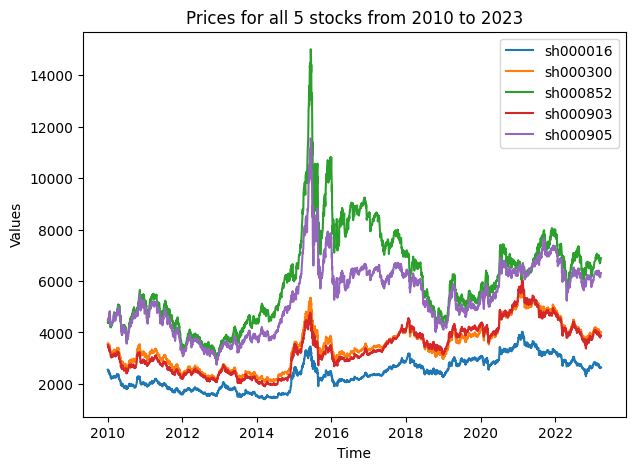

In [6]:
plt.figure(figsize=(7,5),dpi=100)
plt.plot(sh16['close'],label = 'sh000016')
plt.plot(sh300['close'],label = 'sh000300')
plt.plot(sh852['close'],label = 'sh000852')
plt.plot(sh903['close'],label = 'sh000903')
plt.plot(sh905['close'],label = 'sh000905')

# set the plot title, axis labels, and legend
plt.title('Prices for all 5 stocks from 2010 to 2023')
plt.xlabel('Time')
plt.ylabel('Values')
plt.legend()

plt.savefig("price_trends.png")

Observations:
- indices with stocks of larger market capitalizations (e.g. 000016) have smaller variance than indecies with stocks of smaller market cap (e.g. 000852). See stock member stock description in data section;
- In 2015, there's a peak in the close prices of all 5 examined stocks. It was a time when China's economy was growing rapidly and this fueled investor confidence and contributed to the stock market boom. The Chinese governemnt also lowered interest rates at that time and made it easier for people to access credit, leading to a surge in investments in the stock market.

### Close Price Trends with Moving Average

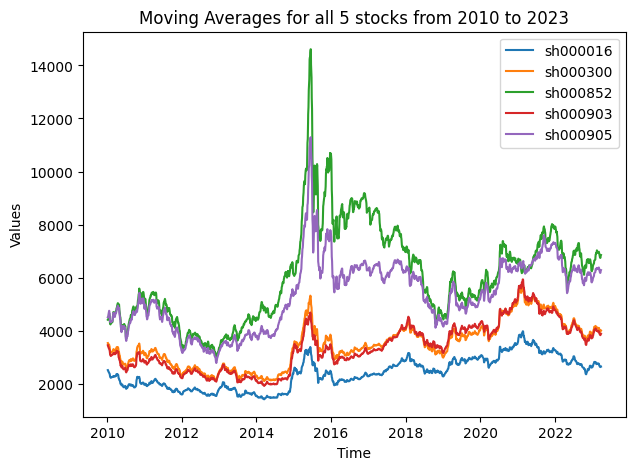

In [7]:
plt.figure(figsize=(7,5),dpi=100)
plt.plot(sh16['close'].rolling(window=5).mean(),label = 'sh000016')
plt.plot(sh300['close'].rolling(window=5).mean(),label = 'sh000300')
plt.plot(sh852['close'].rolling(window=5).mean(),label = 'sh000852')
plt.plot(sh903['close'].rolling(window=5).mean(),label = 'sh000903')
plt.plot(sh905['close'].rolling(window=5).mean(),label = 'sh000905')

# set the plot title, axis labels, and legend
plt.title('Moving Averages for all 5 stocks from 2010 to 2023')
plt.xlabel('Time')
plt.ylabel('Values')
plt.legend()

plt.savefig("price_trends_ma.png")

Observation:
- In addition, we observe that the daily stock prices are highly volatile and can experience a wide range of fluctuations over time. Using the next single day price to determine the trend may lead to unstable results. To address this, we use a moving average to reduce the noise in the data and obtain a clearer representation of the underlying trend. By calculating the average price over a specified period (e.g., $k=5$ days), we can create a smoother curve that captures the general movement of the stock prices, which is expected to facilitate forecasting. 

### Feature Correlations

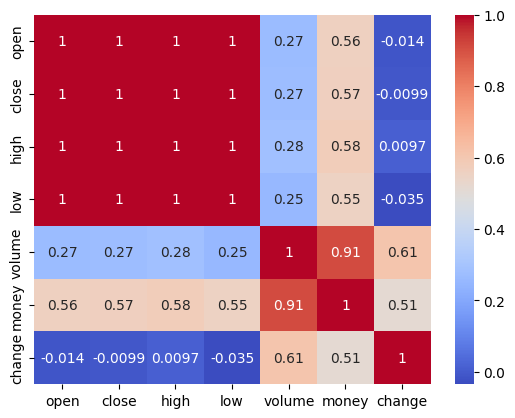

In [8]:
heatmap = sns.heatmap(sh16.iloc[:, 0:7].corr(),cmap='coolwarm',annot=True)
heatmap.get_figure().savefig("heatmap.png")

Observation: 
- From the heatmap above, it is evident that the variables `open`, `close`, `high`, `low`, and `adjclose` exhibit strong positive linear relationships. As a result, we opt to use only the `close` price as our feature and exclude the others. The correlation coefficient between `close` and `volume` is 0.27, while the correlation between `close` and `money` is 0.57. Based on these values, we decide to retain both `volume` and `money` as features in our analysis.

### Distribution of Predictors

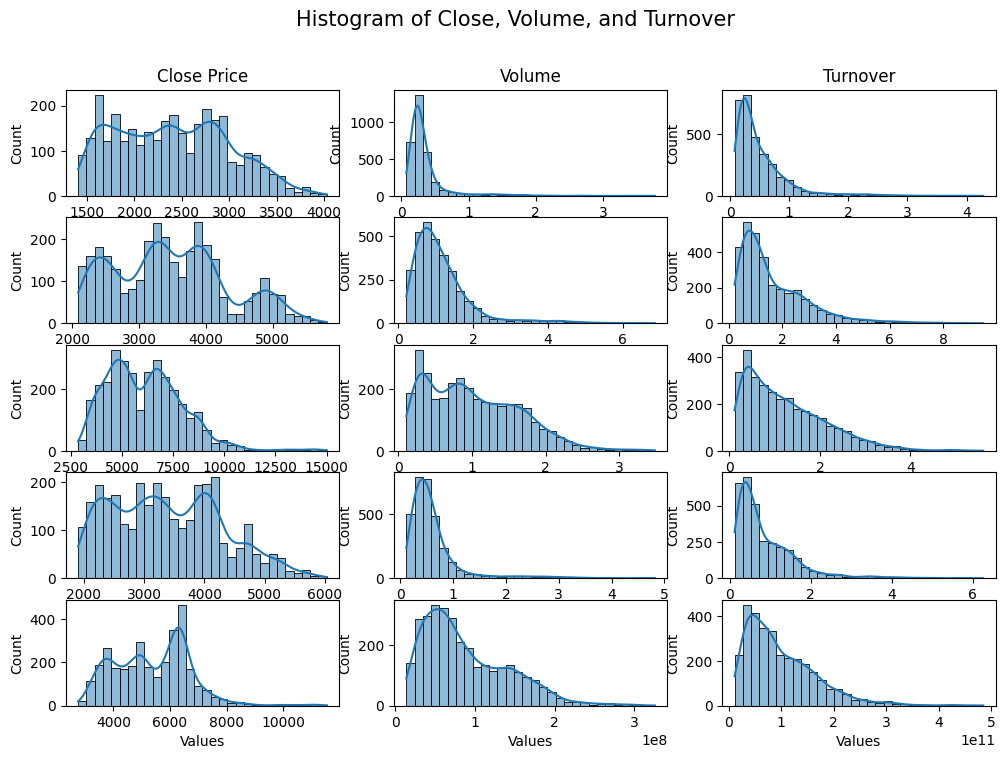

In [9]:
# Create a 5x3 grid of subplots
fig, axs = plt.subplots(nrows=5, ncols=3, figsize=(12, 8))

# Define a list of column names for the three types of data
data_cols = ['close', 'volume', 'money']

# Loop over the rows and columns of the grid
for i in range(5):
    if i == 0:
        stock = sh16
        label = sh16
    elif i == 1:
        stock = sh300
        label = sh300
    elif i == 2:
        stock = sh852
        label = sh852
    elif i == 3:
        stock = sh903
        label = sh903
    else:
        stock = sh905
        label = sh905
    for j in range(3):
        # Get the variable that needs to be visualized
        col = data_cols[j]

        # Plot the data on the current subplot
        sns.histplot(stock[[col]], ax=axs[i,j],kde=True,bins=30,legend=False)
     #   stock_data.plot(ax=axs[i,j], label=label)
        axs[i,j].set_xlabel('Values')
     #   axs[i,j].set_ylabel(col.capitalize())
      #  axs[i,j].legend()
axs[0, 0].set_title('Close Price')
axs[0, 1].set_title('Volume')
axs[0, 2].set_title('Turnover')
plt.suptitle("Histogram of Close, Volume, and Turnover", fontsize=15)
# Show the plot
plt.show()


fig.savefig("histograms.png")

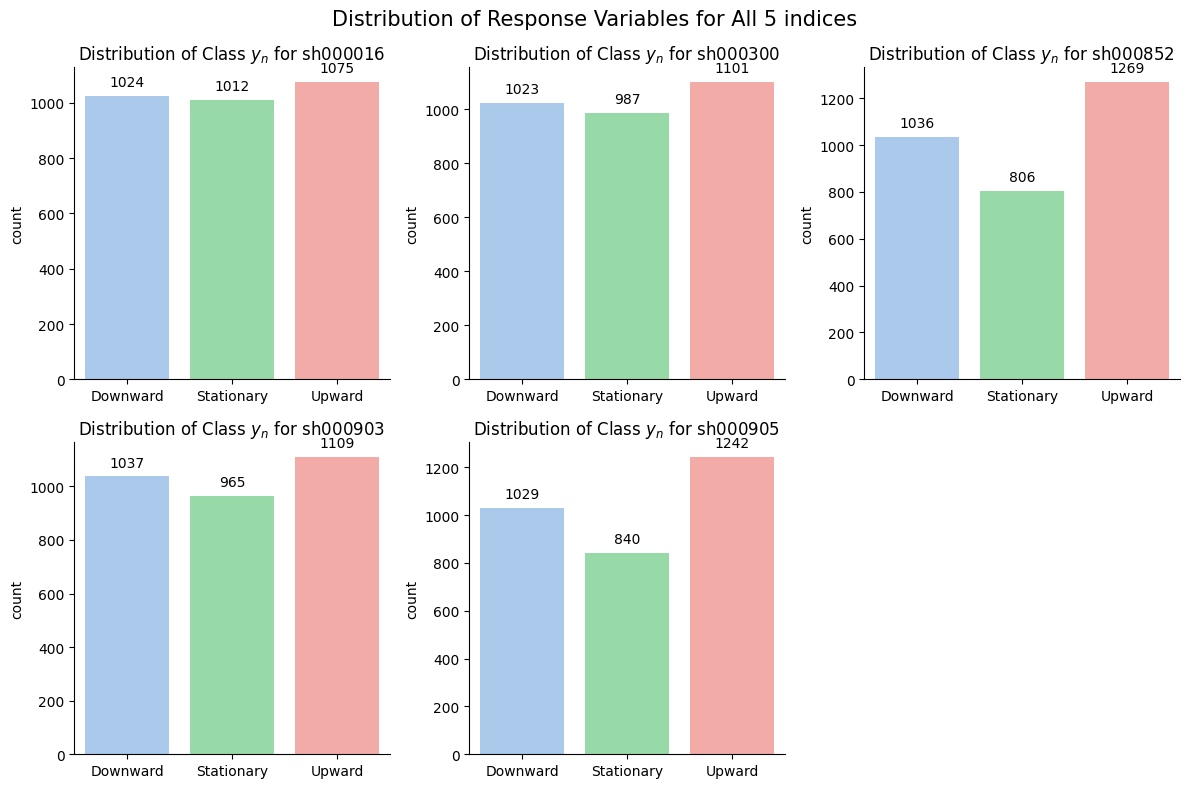

In [10]:
sns.set_palette('pastel6')
#fig, axs = plt.subplots(ncols=2, figsize=(10, 4))
label_dict = {2:'Downward', 0:'Stationary', 1:'Upward'} #2, 0, 1
stock_label = ['sh000016','sh000300','sh000852','sh000903','sh000905']
#set up subplot
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(12, 8))
# axes = axes.flatten()


y_s = [y_16,y_300,y_852,y_903,y_905]

for i, stock in enumerate(y_s):
# Map the array values to their corresponding labels
    label_arr = [label_dict[val] for val in stock]

    ax = sns.countplot(x = label_arr,order=['Downward', 'Stationary','Upward'],ax=axes[i//3,i%3])
    ax.set(title=f"Distribution of Class $y_n$ for {stock_label[i]} ")
    # Add count labels on top of the bars
    for p in ax.patches:
        ax.annotate(format(p.get_height(), '.0f'),
                    (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='center', xytext=(0, 10),
                    textcoords='offset points')

    
# # Remove any unused subplots
# for i in range(len(y_s), len(axes)):
#     fig.delaxes(axes[i])
axes[1,2].remove()
plt.suptitle("Distribution of Response Variables for All 5 indices", fontsize=15)

# Adjust the layout of the subplots
fig.tight_layout()

# Show the plot
sns.despine()
plt.show()

fig.savefig("yn_distribution.png")

We take a look at the distribution of the 3 predictors that we will be using to predict the pricing trend. As we can observe in the histograms above, even after standardization, `volume` and `money` are still quite right-skewed. This may imply that we should use non-parametric models that do not assume a specific distribution of the prediction to perform the prediction task.

### Autocorrelation

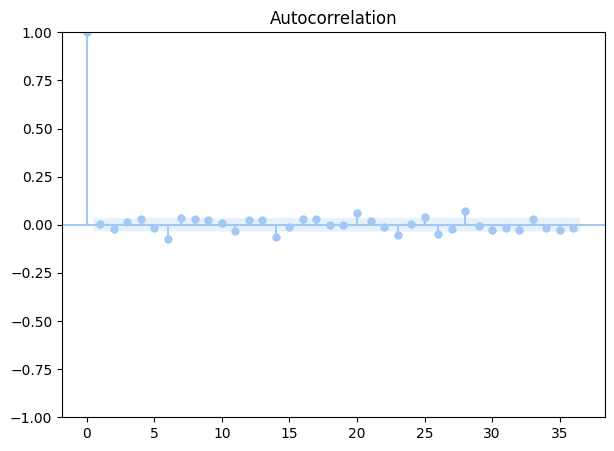

In [11]:
# Plot autocorrelation
fig, ax = plt.subplots(figsize=(7, 5))
price_return = sh16['close'] / sh16['close'].shift(1)
sm.graphics.tsa.plot_acf(price_return[1:], ax=ax)
plt.show()

/Users/kenneth/opt/anaconda3/envs/stp/lib/python3.10/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


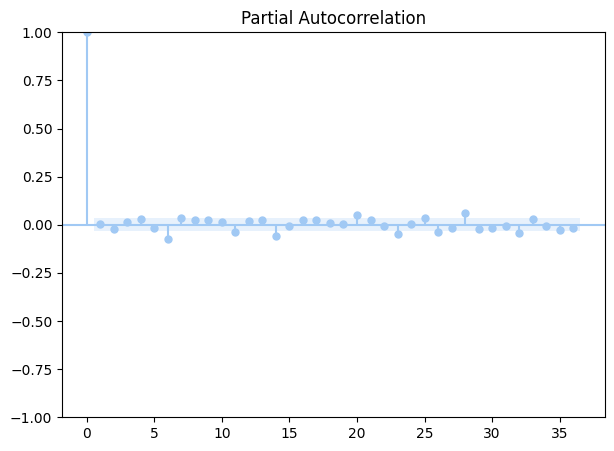

In [12]:
# Plot autocorrelation
fig, ax = plt.subplots(figsize=(7, 5))
price_return = sh16['close'] / sh16['close'].shift(1)
sm.graphics.tsa.plot_pacf(price_return[1:], ax=ax)
plt.show()

Observation: 
- The autocorrelation and partial autocorrelation plots indicate a biweekly negative autocorrelation. The presence of a momentum effect, such as a rise in the market followed by a fall the following week, can be identified by a positive partial autocorrelation at a lag of one week.

### Examine the Target Variable

We examined the distribution of the target variable $y_{n}$ for all 5 stocks. In general, there are no significant class imbalance issues with our chosen threshold $\alpha=0.007$. However, we can see that compared with sh000016, sh000300, sh000903, sh000852 and sh000905 have more "upward" moving trends. This suggests that each stock has its own unique characteristics and factors that affect its price. In light of this, we will build separate models to capture the unique characteristic of each stock. 

### Noteworthy Findings and Meaningful Insights
Based on the previous Exploratory Data Analysis, here is a summary of our main findings and insights:

- **Market style changes dramatically across time**: for example, all indices experienced a price peak in 2015, which was a result of an excessive amount of speculation in the Chinese stock market. They then transitioned into a dramatic decline in the following months. This suggests predictions should be trained on the immediate pasts of a constrainted period instead of the entire past. See the rolling train-test-split figure in the "Baseline Model" section.

- **High correlations between price-related variables**: all the price-related variables, such as "open", "close", "high", "low" and "adjclose" have perfect positive linear relationships. To avoid high correlations between predictors, we will be using only "close", "volume" and "money" in model training.

- **Highly right-skewed data distribution**: The distribution of predictors "volume" and "money" is still quite right-skewed after the standardization, suggesting the necessity of using non-linear models to perform the forecasting task.

- **Ununiformed characteristics among different indices**: In terms of close price, the volatility is different for each index. sh000852 fluctuates much more than sh000016. In terms of the distribution of target variables, sh000852 and sh000905 have more "upward" observations compared with the other 3 stocks. Due to the uniqueness of each stock, we may need to build separate models for each index to capture their unique characteristics.


## Project Question

With findings and insights above, we would like to answer the following questions through our project analysis: 

- **Does Multiscale-CNN adapts to different market styles across time? How robust is our proposed model to market style changes?** we would need to answer this by examining test accuracy across different testing periods trained on the immediate past. 

- **How much does non-linearity buy us in tackling right-skewed data distribution?** We would need to answer this by comparing our performance with a naive linear model. 

- **How robust is Multiscale-CNN to different inputs?** We would need to compare performance of our models separately trained on five indices. 

## 4. Methodology <a class="anchor" id="methodology"></a>

### Organization of Codes

The following is the organization of codes. More details can be find in readme of the repository [here](https://github.com/yangshengaa/multiscale_cnn_stp).  

```
code/  
┣ command/  
┃ ┣ baseline_demo.sh  
┃ ┗ nn_demo.sh  
┣ data/  
┃ ┣ preprocessed/  
┃ ┃ ┣ 000016/  
┃ ┃ ┃ ┣ X.npy  
┃ ┃ ┃ ┣ dates.pkl  
┃ ┃ ┃ ┗ y.npy  
┃ ┃ ┣ 000300/  
┃ ┃ ┃ ┣ X.npy  
┃ ┃ ┃ ┣ dates.pkl   
┃ ┃ ┃ ┗ y.npy  
┃ ┃ ┣ 000852/  
┃ ┃ ┃ ┣ X.npy   
┃ ┃ ┃ ┣ dates.pkl  
┃ ┃ ┃ ┗ y.npy  
┃ ┃ ┣ ...
┃ ┣ raw/  
┃ ┃ ┣ sh000016.csv  
┃ ┃ ┣ sh000300.csv  
┃ ┃ ┣ sh000852.csv  
┃ ┃ ┣ ...  
┃ ┗ .gitkeep  
┣ img/  
┣ model/  
┃ ┣ ... # store model weights   
┣ notebook/  
┃ ┣ .gitkeep   
┃ ┣ MS4.ipynb   
┃ ┣ final_report.ipynb    
┣ result/    
┃ ┣ ... # store prediction results  
┣ src/   
┃ ┣ data/   
┃ ┃ ┣ DataGenerator.py  
┃ ┃ ┣ __init__.py  
┃ ┃ ┣ preprocess.py  
┃ ┃ ┗ util.py  
┃ ┣ model/  
┃ ┃ ┣ CNN.py   
┃ ┃ ┣ MLP.py    
┃ ┃ ┗ __init__.py  
┃ ┣ utils/    
┃ ┃ ┣ __init__.py   
┃ ┃ ┣ config.py    
┃ ┃ ┗ model_log.py  
┃ ┣ run_baseline.py   
┃ ┗ run_nn.py  
┣ .gitignore  
┣ LICENSE  
┣ README.md  
┗ config.toml  
```

There are two major components: data and source code. The data folder stores the raw and preprocessed data, and source code store all python scripts. In src folder, we have three subfolders: preprocess.py stores data preprocessing scripts, and utils.py facilitate data IO and train test split; model folder stores the corresponding proposed model; utils folder helps with organizing logging and paths of logging.

### Code Library Dependency

See instruction to setup the environment [here](https://github.com/yangshengaa/multiscale_cnn_stp). The essential parts of the environment consists of the following packages built on Python 3.8: 
- torch==2.0.0
- tensorboard
- toml
- statsmodels
- tqdm

For readers' convenience, the conda setup is also pasted here:

```bash
# setup necessary packages to run this repository
conda create -n stp
conda activate stp
conda install python==3.8
pip3 install torch torchvision torchaudio
pip install --no-cache-dir autopep8 jupyterlab toml timebudget tensorboard torch-tb-profiler
pip install --no-cache-dir statsmodels seaborn scipy pillow xgboost tqdm scikit-learn gpustat
pip install -e .
```

### Preprocessing

The following code defines our data preprocessing pipeline for stock market data, which includes three main parts:

- Creates rolling windows of features from the original index data and calculates target labels based on the close price changes. The labels are assigned as -1, 0, or 1 and then mapped to 0, 1, or 2.
- Standardizes each feature within its respective rolling window by calculating the mean and standard deviation.
- Winsorizes the features by limiting the absolute values to 2, which helps reduce the impact of outliers.

The following is the preprocessing methods.

```python
def read_index_data(name: str) -> pd.DataFrame:
    """read csv"""
    csv_path = os.path.join('../../', paths['data_dir'], 'raw', f'sh{name}.csv')
    df = pd.read_csv(csv_path, index_col=0, usecols=['date', 'close', 'volume', 'money'])
    # change nmae 
    df.columns = ['close', 'volume', 'turnover']
    return df 

def get_features_and_targets(df: pd.DataFrame) -> Tuple[np.ndarray, np.ndarray, List]:
    """create rolling window and readoff dates"""
    # dates 
    dates = df.index.tolist()[args.t - 1: - args.k] # chop off look-forward and backward ates
    # features 
    X = np.array(list(df.iloc[:-args.k].rolling(args.t))[args.t - 1:])  # shape:  (# num features, args.t, 3)
    # targets 
    close_price = df['close']
    close_change = ((close_price.rolling(args.k).mean().shift(-args.k) - close_price) / close_price).dropna()[dates] 
    y = (close_change.abs() > args.thr) * ((close_change > 0) * 2 - 1) # (assign labels -1, 0, 1)
    y = y % 3   # change label -1 to label 2
    y = y.to_numpy().astype(int) 

    return X, y, dates

def standardize_data(X: np.ndarray) -> np.ndarray:
    """standardize each features within respective rolling window"""
    X_mean = X.mean(axis=0, keepdims=True)
    X_std = X.std(axis=0, keepdims=True)
    X_standardized = (X - X_mean) / X_std
    return X_standardized

def winsorize_data(X: np.ndarray) -> np.ndarray:
    """winsorize each features to be within """
    X_winsorized = np.where(X.abs() > 2, 2 * np.sign(X), X)
    return X_winsorized

def save_data(X: np.ndarray, y: np.ndarray, dates: List, name: str):
    """save to dir"""
    cur_dir = os.path.join(store_path, name)
    os.makedirs(cur_dir, exist_ok=True)
    np.save(os.path.join(cur_dir, "X.npy"), X)
    np.save(os.path.join(cur_dir, 'y.npy'), y)
    with open(os.path.join(cur_dir, 'dates.pkl'), 'wb') as f:
        pickle.dump(dates, f)
    

# ==== main ====
def main():
    for index_name in args.data:
        df = read_index_data(index_name)
        X, y, dates = get_features_and_targets(df)
        if args.standardize: X = standardize_data(X)
        if args.winsorize: X = winsorize_data(X)

        # save 
        save_data(X, y, dates, index_name)


if __name__ == '__main__':
    main()
```

### Model Architecture and Design

Before moving to convolution neural network, we will start with multi-logistic regression and fully connected neural net with flattened features (i.e. time-ignorant) to benchmark our performance. We will use accuracy and macro f1 to test model performance.

#### Baseline Model

We chose multinomial logistic regression, also known as multi-logistic regression, as our baseline model. It is an extension of binary logistic regression, which can only handle dependent variables with two categories. Here are some reasons for using multinomial logistic regression:

- Multiple categories: Multinomial logistic regression can handle dependent variables with three or more categories, making it ideal for our problems as we have three classes: up, down, stationary.

- Interpretability: The results from a multinomial logistic regression are interpretable, as they provide information on the odds ratios and probabilities associated with each category of the dependent variable, given the values of the independent variables.

- Relationship modeling: Multinomial logistic regression can model the relationship between the independent variables and the log-odds of the dependent variable, allowing us to understand the factors influencing the outcome and make predictions. We will further analyze important features in future work.

We rely on scikit-learn implementation of LogisticRegression to accomplish testing.

The following is a snapshot of our testing loop.

```python
def train():
    """train loop"""
    for period_dict, target_dict, dates_dict in ts_split(
            data, targets, dates, args.train, args.val, args.test, args.K, 
            make_tabular=True, return_tensor=False
        ):
        period_start_date = dates_dict['train'][0][0]
        period_end_date = dates_dict['test'][-1]
        print(f'====== {period_start_date} to {period_end_date} =======')

        # use average validation accuracy to pick the best hyperparameter
        val_avg_acc = []
        for c in args.C:
            cur_val_acc = []
            for fold, (X_train, X_val, y_train, y_val) in enumerate(zip(
                    period_dict['train'], period_dict['val'], target_dict['train'], target_dict['val']
                )):
                # train 
                mlr = LogisticRegression(penalty='l2', C=c).fit(X_train, y_train)
                cur_acc = mlr.score(X_val, y_val)

                # print 
                if args.verbose:
                    print(f"c = {c}: fold = {fold}, val acc = {cur_acc}")
                
                cur_val_acc.append(cur_acc)
            avg_acc = np.mean(cur_val_acc)
            val_avg_acc.append(avg_acc) 
        
        # find best hyperparameter
        best_param_idx = np.argmax(val_avg_acc)
        best_c, bets_val_avg_acc = args.C[best_param_idx], val_avg_acc[best_param_idx]
        print(f"selected param: c = {best_c}, val avg acc: {bets_val_avg_acc:.4f}")
        
        # retrain 
        mlr = LogisticRegression(penalty='l2', C=best_c).fit(period_dict['train_all'], target_dict['train_all'])
        test_pred = mlr.predict(period_dict['test'])
        test_y = target_dict['test']
        test_acc = accuracy_score(test_y, test_pred)
        test_f1 = f1_score(test_y, test_pred, average='macro')  # TODO: maybe weighted? need discussion
        print(f"test metrics: acc = {test_acc:.4f}, f1 = {test_f1:.4f}")

        # log 
        # save model hyperparam to 
        log_baseline_params(best_c, period_start_date, period_end_date, model_path)
        log_predictions(test_pred, dates_dict['test'], result_path)
        print()
```

#### Multi-Scale Convolutional Neural Network

To automatically learn the multi-scale information in stock data, we propose a Multi-scale Convolutional Neural Network. The main advantage of using a multi-scale CNN for stock trend prediction is that it can effectively capture different scales of patterns in the financial time series data, such as daily, weekly, or monthly trends, which can be difficult to capture using traditional machine learning methods. A multi-scale CNN can learn features at multiple scales simultaneously, allowing it to capture a wider range of patterns in the data.

The model architecture is summarized below.

<img src="./diagram.png" alt="Drawing" width="1200"/>
<!-- ![diagram.png](diagram.png) -->

Our proposed model consists of four main parts: 

1. **Downsampling** into multi-scale formations: let $s$ be the scale for downsampling. Similar to max pooling with a stride of s, we skip $s$ timestamps between each window movement, and the output feature map's size is effectively reduced by a factor of $s$ in height but stay with the same width.
2. Utilizing **CNNs** to obtain multi-scale spatial features: we follow the structure of CNNpred, which is a stock data-oriented CNN for STP task; it consists of 5 CNN layers: the first layer is a 1D convolution over features with 16 filters of $1 \times 3$, after which is stacked with two convolutional layers with 32 filters of $1 \times 3$, each followed by a $2 \times 1$ max-pooling layer. 
3. **Concatenation** of multi-scale vectors to a single one: we pad the output of each scale to same length of 25 and concatenate along scales; the concatenated result has width 25 and height $32 \times s$
4. **GRU** and output: We use Gated Recurrent Unit (GRU) to temporally cascade information, and the last hidden state is passed to a fully connected neural network to output the category prediction results $\in \mathbb{R}^3$. We use cross-entropy as our loss function to measure the difference.

The following is the implementation of the above architecture.

```python
from typing import List

import torch
import torch.nn as nn
import torch.nn.functional as F

class CNN(nn.Module):
    def __init__(self, window_size=100, n_features=3, n_filters=32, output_dim=3, scale=1, nl=nn.ReLU()) -> None:
        super(CNN, self).__init__()
        self.scale = scale
        self.window_size = window_size
        self.nl = nl

        conv1_list = []
        conv2_list = []
        conv3_list = []
        for s in range(1, scale+1):
            conv1_list.append(nn.Conv2d(1, n_filters//2, kernel_size=(1, n_features)))
            conv2_list.append(nn.Conv2d(n_filters//2, n_filters, kernel_size=(3, 1), padding='same'))
            conv3_list.append(nn.Conv2d(n_filters, n_filters, kernel_size=(3, 1), padding='same'))

        self.conv1_list = nn.ModuleList(conv1_list)
        self.conv2_list = nn.ModuleList(conv2_list)
        self.conv3_list = nn.ModuleList(conv3_list)
        self.pool = nn.MaxPool2d(kernel_size=(2, 1))
        self.fc = nn.Linear(scale*n_filters, output_dim)
        self.gru = nn.GRU(scale*n_filters, scale*n_filters, batch_first=True)

    def forward(self, X: torch.Tensor) -> torch.Tensor:
        feature_list = []
        X = torch.unsqueeze(X, 1)
        for s in range(self.scale):
            indices = [i for i in range(self.window_size) if i % (s+1) == 0]
            x = X[:, :, indices, :]
            x = self.nl(self.conv1_list[s](x))
            x = self.nl(self.conv2_list[s](x))
            x = self.pool(x)
            x = self.nl(self.conv3_list[s](x))
            x = self.pool(x)
            x = x.squeeze()
            if s == 0:
                L = x.shape[-1]
            else:
                x = F.pad(x, (L-x.shape[-1], 0))
            feature_list.append(x)
        x = torch.cat(feature_list, 1)
        x = x.permute(0, 2, 1)
        x = self.gru(x)[1].squeeze()
        x = self.fc(x)
        return x
```

The following is the training loop for CNN:

```python
def get_model() -> nn.Module:
    """retrieve model according to parameters"""
    # get nonlinearity 
    nl = getattr(nn, args.nl)()

    # get model
    if args.model == "CNN":
        window_size, num_features, output_dim = 100, 3, 3
        model = CNN(window_size, num_features, args.num_filters, output_dim, args.scale, nl).to(device)
    else:
        raise NotImplementedError()
    
    return model

def train():
    """train loop for neural net"""
    make_tabular = args.model == 'MLP'
    for period_dict, target_dict, dates_dict in ts_split(
            data, targets, dates, args.train, args.val, args.test, args.K, 
            make_tabular=make_tabular, return_tensor=True
        ):
        period_start_date = dates_dict['train'][0][0]
        period_end_date = dates_dict['test'][-1]
        print(f'====== {period_start_date} to {period_end_date} =======')

        # ================= cross validation ===============
        # use average validation accuracy to pick the best hyperparameter
        # ! now it is just a fake cross validation
        val_avg_acc = []
        for wd in [args.wd]:  # TODO: figure out what hyperparameters want to be tested
            cur_val_acc = []
            for fold, (X_train, X_val, y_train, y_val) in enumerate(zip(
                    period_dict['train'], period_dict['val'], target_dict['train'], target_dict['val']
                )):
                # send to device (full batch training)
                X_train, X_val, y_train, y_val = X_train.to(device), X_val.to(device), y_train.to(device), y_val.to(device)

                # get model 
                model = get_model()

                # initialize optimizer
                opt = getattr(torch.optim, args.opt)(model.parameters(), lr=args.lr, weight_decay=wd)

                # train 
                loop = range(args.epochs)
                if args.verbose: loop = tqdm(loop)
                model.train()
                for e in loop:
                    opt.zero_grad()
                    outputs = model(X_train)
                    loss = loss_func(outputs, y_train)
                    loss.backward()
                    opt.step()

                    if args.verbose:
                        loop.set_description(f"wd = {wd}, fold = {fold}")
                        loop.set_postfix_str(f"train loss = {loss.item():.4f}") 
                
                # validate
                model.eval()
                with torch.no_grad():
                    val_outputs = model(X_val)
                    val_pred = val_outputs.argmax(dim=1)
                    cur_acc = accuracy_score(y_val.detach().cpu().numpy(), val_pred.detach().cpu().numpy())
                    cur_val_acc.append(cur_acc)

                # print 
                if args.verbose:
                    print(f"wd = {wd}: fold = {fold}, val acc = {cur_acc}")
                
                cur_val_acc.append(cur_acc)
            avg_acc = np.mean(cur_val_acc)
            val_avg_acc.append(avg_acc) 
        
        # find best hyperparameter
        best_param_idx = np.argmax(val_avg_acc)
        best_param, bets_val_avg_acc = [args.wd][best_param_idx], val_avg_acc[best_param_idx]
        print(f"selected param: wd = {best_param}, val avg acc: {bets_val_avg_acc:.4f}")
        
        # =========== retrain ===========
        # send to device
        X_train_all, y_train_all = period_dict['train_all'].to(device), target_dict['train_all'].to(device)
        X_test, y_test = period_dict['test'].to(device), target_dict['test'].to(device)

        # get model 
        model = get_model()

        # initialize optimizer
        opt = getattr(torch.optim, args.opt)(model.parameters(), lr=args.lr, weight_decay=args.wd)

        # train 
        loop = range(args.epochs)
        if args.verbose: loop = tqdm(loop)
        model.train()
        for e in loop:
            opt.zero_grad()
            outputs = model(X_train_all)
            loss = loss_func(outputs, y_train_all)
            loss.backward()
            opt.step()

            if args.verbose:
                loop.set_description(f"testing loop: ")
                loop.set_postfix_str(f"train loss = {loss.item():.4f}") 
        
        # validate
        model.eval()
        with torch.no_grad():
            test_outputs = model(X_test)
            test_pred = test_outputs.argmax(dim=1)
            test_acc = accuracy_score(y_test.detach().cpu().numpy(), test_pred.detach().cpu().numpy())
            test_f1 = f1_score(y_test.detach().cpu().numpy(), test_pred.detach().cpu().numpy(), average='macro')  # TODO: maybe weighted? need discussion
            print(f"test metrics: acc = {test_acc:.4f}, f1 = {test_f1:.4f}")

        # log 
        # save model hyperparam (this is also fake now, need to decide what hyperparameters are to be tested)
        log_baseline_params(best_param, period_start_date, period_end_date, model_path)
        # the following line is memory intensive
        if args.log_weights: log_nn_params(model, period_start_date, period_end_date, model_path)
        log_predictions(test_pred.detach().cpu().numpy(), dates_dict['test'], result_path)
        print()
```

## 5. Training and Model Evaluation <a class="anchor" id="train_eval"></a>

### Training details
- **Loss function**: cross-entropy
- **Optimization algorithm**: Adam
- **Learning rate**: 0.01
- **Epochs**: 200
- **Batch size**: Full batch

### Time Series Train Validation Test Split

<!-- ![Time Series Train Validation Test Split](train_test_split.png)  -->
<img src="./Train_test.jpg" alt="Drawing" width="1000"/>
<!-- ![Train_test.jpg](Train_test.jpg)   -->

We perform a sliding window cross-validation with a step size of 40 days. In each pass, a 5-fold cross-validation is performed to optimize the hyperparameters and evaluate the model on a test set of 40 days. This approach allows for a more accurate estimation of the model's performance and generalization ability over different periods of time. Below is a summary of the process for each pass:

For Pass $i$:

1. Train the model on a training set of shape (240, 100, 3), consisting of 240 data points. Each data point $X_i \in \mathbb{R}^{100×3}$ represents 100 days of 3 predictors (close, volume, and turnover).
2. Evaluate the model on the subsequent 40 days (validation set) and calculate the average validation loss for the 40 days, $L_i^{\text{(1)}}$.
3. Slide the window to the right by 40 days and repeat this process for a total of 5 folds. Calculate the average validation loss for each fold, $L_i^{\text{(k)}}$, where $k = 1, 2, 3, 4, 5$.
4. Compute the average of the 5-fold validation losses: $\frac{1}{5}\sum_{k=1}^{5} L_i^{\text{(k)}}$. Use this average to choose the best set of hyperparameters.
5. Evaluate the model with the optimal set of hyperparameters on a test set of 40 days.
After completing the pass, move forward by 40 days and start pass $i+1$. Repeat the entire process from steps 1 to 5.



The following implements the train test split described above. 

```python
def ts_split(
    data: np.ndarray,
    targets: np.ndarray,
    dates: List[str],
    train: int = 240,
    val: int = 40,
    test: int = 40,
    K: int=5,
    make_tabular=False,
) -> Tuple:
    """
    time series train test split
    :param data: the feature data of shape (length, 100, 3)
    :param targets: the target data of shape (length, )
    :param dates: the corresponding dates of shape (length, )
    :param train, val, test: the number of days for train, val, and test data
    :param K: the number of folds for validation 
    :param make_tabular: True to make dataset tabular
    :return generated slices of data, target, and dates packed in dict, with the following pairs:
        - "train": list of data/targets/dates of length K 
        - "val": list of data/targets/dates of length K 
        - "test": a single period test
    """
    # flatten dataset to be tabular
    if make_tabular:
        data = data.reshape(len(data), -1)

    total_length = data.shape[0] 
    period_length = train + val * K + test
    period_start_idx = 0 

    while period_start_idx + period_length < total_length:
        period_dict, target_dict, dates_dict = [{'train': [], 'val': []} for _ in range(3)]
        cur_idx = period_start_idx

        # gather K-fold validations
        for _ in range(K):
            # slice
            # train
            train_data = data[cur_idx:cur_idx + train]
            train_targets = targets[cur_idx:cur_idx + train]
            train_dates = dates[cur_idx:cur_idx + train]

            # validation
            val_data = data[cur_idx + train:cur_idx + train + val]
            val_targets = targets[cur_idx + train:cur_idx + train + val]
            val_dates = dates[cur_idx + train:cur_idx + train + val]

            # append to dict
            period_dict['train'].append(train_data)
            target_dict['train'].append(train_targets)
            dates_dict['train'].append(train_dates)
            period_dict['val'].append(val_data)
            target_dict['val'].append(val_targets)
            dates_dict['val'].append(val_dates)

            # update start index of each fold
            cur_idx += val

        # pack test
        test_data = data[cur_idx + train + val: cur_idx + train + val + test]
        test_targets = targets[cur_idx + train + val: cur_idx + train + val + test]
        test_dates = dates[cur_idx + train + val: cur_idx + train + val + test]

        period_dict['test'] = test_data
        target_dict['test'] = test_targets
        dates_dict['test'] = test_dates

        # also feed in "train_all": from start of this period to end of val
        period_dict['train_all'] = data[period_start_idx:cur_idx + train + val]
        target_dict['train_all'] = targets[period_start_idx:cur_idx + train + val]

        yield period_dict, target_dict, dates_dict

        # update period start (move by test)
        period_start_idx += test
```

## 6. Results <a class="anchor" id="results"></a>

In [16]:
mlr_pred = pd.read_csv("../result/demo/mlr_000016/predictions.csv")
cnn_pred = pd.read_csv("../result/demo/CNN_000016_tr240_va40_te40/predictions.csv")

**F1 Score and Accuracy of baseline model (logistic regression) vs. our model (multi-scale cnn)**

In [17]:
y_16_true = y_16[440:3071]

mlr_f1_all = f1_score(y_16_true, mlr_pred["prediction"], average="weighted")
mlr_accuracy_all = accuracy_score(y_16_true, mlr_pred['prediction'])
cnn_f1_all = f1_score(y_16_true, cnn_pred["prediction"], average="weighted")
cnn_accuracy_all = accuracy_score(y_16_true, cnn_pred['prediction'])

models_scores = [
    {"Model": "Logistic Regression", "Accuracy": mlr_accuracy_all, "F1 Score": mlr_f1_all},
    {"Model": "Multi-scale CNN", "Accuracy": cnn_accuracy_all, "F1 Score": cnn_f1_all},
]

print(pd.DataFrame(models_scores).set_index("Model"))

                     Accuracy  F1 Score
Model                                  
Logistic Regression  0.366401  0.364416
Multi-scale CNN      0.357659  0.357175


Both the F1 score and accuracy appear to be highly volatile and fluctuating over time for both the baseline model and the multi-scale CNN model. This suggests that the models' performance is not consistent over time, and there may be certain time periods where they perform better or worse than others.

The fact that the F1 score and accuracy both exhibit a wide range of values also suggests that the models may not be robust enough to capture all the patterns in the financial time series data, and may be affected by noise and other sources of variability.

However, the multi-scale CNN model does have the advantage of exhibiting less variance than the baseline logistic regression model. This suggests that it may be more stable and less susceptible to overfitting, which could be an advantage in certain contexts.

Overall, the results suggest that there is still room for improvement in our model, and that further fine-tuning (e.g. scale $s$) may be necessary to achieve better performance. It is also worth noting that there may be other factors that are affecting the models' performance, such as changes in market conditions or changes in the underlying dynamics of the stocks being analyzed.

**Hyperparameters**


In [ ]:
parameters = pd.read_csv("../model/demo/mlr_000016/hyperparam.csv")
parameters.info()

In [ ]:
parameters.plot(x="end_date", y="best_c", xlabel="Time Window", ylabel="Best Hyperparameter", title="Best Hyperparameter over Time", rot=45, logy=True)
plt.show()

Based on the plot of the best hyperparameter value over time, it appears that the value is highly unstable and varies widely, ranging from 0.1 to 100 over time. This suggests that more advanced models that can take time into account may be necessary, rather than relying on the baseline multi-logistic regression model. 

### Abalation study: varying training size and random seeds

We want to see how training sizes will affect the models' performances. Therefore, we trained both MLR and CNN with 3 different training sizes: 480, 1000 and 2400. For CNN, we also train the same choice of training size with 3 different seeds

In [19]:
train_sizes = [480,1000,2400]
seeds = [401,402,403]

In [20]:
def get_master_list(index_str):
    """get a master data list for an stock index"""
    # Construct file paths using index_str
    y_file_path = f"../data/preprocessed/{index_str}/y.npy"
    dates_file_path = f"../data/preprocessed/{index_str}/dates.pkl"
    mlr_pred_480_path = f"../result/mlr_{index_str}_tr480_va40_te40/predictions.csv"
    mlr_pred_1000_path = f"../result/mlr_{index_str}_tr1000_va40_te40/predictions.csv"
    mlr_pred_2400_path = f"../result/mlr_{index_str}_tr2400_va40_te40/predictions.csv"
    cnn_pred_480_path_template = f"../result/CNN_{index_str}_tr480_va40_te40_lr0.005_e200_seed{{}}/predictions.csv"
    cnn_pred_1000_path_template = f"../result/CNN_{index_str}_tr1000_va40_te40_lr0.005_e200_seed{{}}/predictions.csv"
    cnn_pred_2400_path_template = f"../result/CNN_{index_str}_tr2400_va40_te40_lr0.005_e200_seed{{}}/predictions.csv"
    
    # Read the data files
    y = np.load(y_file_path)
    with open(dates_file_path, 'rb') as f:
        dates = pickle.load(f)
    true = pd.DataFrame({'date': dates, 'true': y})
    mlr_pred_480 = pd.read_csv(mlr_pred_480_path)
    mlr_pred_1000 = pd.read_csv(mlr_pred_1000_path)
    mlr_pred_2400 = pd.read_csv(mlr_pred_2400_path)
    cnn_pred_480 = [pd.read_csv(cnn_pred_480_path_template.format(seed)) for seed in [401, 402, 403]]
    cnn_pred_1000 = [pd.read_csv(cnn_pred_1000_path_template.format(seed)) for seed in [401, 402, 403]]
    cnn_pred_2400 = [pd.read_csv(cnn_pred_2400_path_template.format(seed)) for seed in [401, 402, 403]]
    
    # Merge true and predictions
    mlr_pred_480 = pd.merge(mlr_pred_480, true, on='date', how='left')
    mlr_pred_1000 = pd.merge(mlr_pred_1000, true, on='date', how='left')
    mlr_pred_2400 = pd.merge(mlr_pred_2400, true, on='date', how='left')
    cnn_pred_480 = [pd.merge(df, true, on='date', how='left') for df in cnn_pred_480]
    cnn_pred_1000 = [pd.merge(df, true, on='date', how='left') for df in cnn_pred_1000]
    cnn_pred_2400 = [pd.merge(df, true, on='date', how='left') for df in cnn_pred_2400]
    
    # Create master data list
    master_list = [[mlr_pred_480, mlr_pred_1000, mlr_pred_2400], [cnn_pred_480, cnn_pred_1000, cnn_pred_2400]]
    
    return master_list


In [21]:
def get_scores(df_list):
    """print metric scores"""
    #Function that takes in a cnn's nested list and print the metrics for different training sizes and seed
    for i,tr in enumerate([480,1000,2400]):
        print(f"For trainng size {tr}:")
        if len(df_list[i]) != 3: #for MLR
            y_true = df_list[i]['true']
            y_pred = df_list[i]['prediction']
            # accuracy
            accuracy = accuracy_score(y_true, y_pred)
            print(f"MLR accuracy: ", accuracy)
            # F1 score
            f1 = f1_score(y_true, y_pred, average = 'macro')
            print(f"MLR F1 score: ", f1)
        else:
            for j in range(3): #for CNN
                y_true = df_list[i][j]['true']
                y_pred = df_list[i][j]['prediction']
                # accuracy
                accuracy = accuracy_score(y_true, y_pred)
                print(f"Accuracy of seed 40{j+1}: ", accuracy)
                # F1 score
                f1 = f1_score(y_true, y_pred, average = 'macro')
                print(f"F1 score of seed 40{j+1}: ", f1)
            print(f"\n")

In [22]:
def get_metrics(df):
    """get 40-days accuracies and f1 scores"""
    #function that takes the data with the chosen training size and 
    #best seed and outputs data for 40-day window
    
    # Initialize empty lists to store the F1 score and accuracy for each time window
    f1_scores = []
    accuracies = []
    x_ticks = []

    # Loop over the data in 40-day windows
    for i in range(0, len(df), 40):
        # Get the data for the current 40-day window
        window_data = df.iloc[i:i+40]
    
        # Compute the F1 score and accuracy for the current window
        f1 = f1_score(window_data['true'], window_data['prediction'], average='weighted')
        accuracy = accuracy_score(window_data['true'], window_data['prediction'])
    
        # Append the results to the lists
        f1_scores.append(f1)
        accuracies.append(accuracy)
    
        # Get the end date for the current window
        end_date = window_data.iloc[-1]['date']
        x_ticks.append(str(end_date))

    # Create a new DataFrame to store the results
    results = pd.DataFrame({'F1 score': f1_scores, 'Accuracy': accuracies})
    
    return x_ticks, results

### sh000016

### MLR

In [23]:
get_scores(get_master_list('000016')[0]) 
train_size_mlr_016 = 1000

#Get MLR's accuracy and f1 score and their variances to store them in the table
df = get_master_list('000016')[0][train_sizes.index(train_size_mlr_016)]
mlr_accuracy_016 = accuracy_score(df['true'], df['prediction'])
mlr_f1_score_016 = f1_score(df['true'], df['prediction'],average = 'macro')
#np.mean(metrics_cnn['Accuracy'])

##Variance
_, metrics_mlr = get_metrics(get_master_list('000016')[0][train_sizes.index(train_size_mlr_016)])
mlr_accuracy_var_016 = np.var(metrics_mlr['Accuracy'])
mlr_f1_score_var_016 = np.var(metrics_mlr['F1 score'])

For trainng size 480:
MLR accuracy:  0.3605186114596403
MLR F1 score:  0.36010428400769906
For trainng size 1000:
MLR accuracy:  0.36878674505611975
MLR F1 score:  0.3683713471800898
For trainng size 2400:
MLR accuracy:  0.32908704883227174
MLR F1 score:  0.3040672166817339


### CNN

In [24]:
get_scores(get_master_list('000016')[1])

index_str = '000016'
train_size_016 = 1000

seed_016 = 402
#Get accuracy and f1 score and their variances to store them in the table
df = get_master_list(index_str)[1][train_sizes.index(train_size_016)][seeds.index(seed_016)]
avg_accuracy_016 = accuracy_score(df['true'], df['prediction'])
f1_score_016 = f1_score(df['true'], df['prediction'],average = 'macro')
#np.mean(metrics_cnn['Accuracy'])

##Variance
_, metrics_cnn = get_metrics(get_master_list(index_str)[1][train_sizes.index(train_size_016)][seeds.index(seed_016)])
accuracy_var_016 = np.var(metrics_cnn['Accuracy'])
f1_score_var_016 = np.var(metrics_cnn['F1 score'])

For trainng size 480:
Accuracy of seed 401:  0.3504809703053116
F1 score of seed 401:  0.34929386850109584
Accuracy of seed 402:  0.3437892095357591
F1 score of seed 402:  0.3438028386043472
Accuracy of seed 403:  0.33877038895859474
F1 score of seed 403:  0.3365794229089217


For trainng size 1000:
Accuracy of seed 401:  0.344735435595938
F1 score of seed 401:  0.34217810658184195
Accuracy of seed 402:  0.36023516835916625
F1 score of seed 402:  0.3596040582851874
Accuracy of seed 403:  0.36130411544628543
F1 score of seed 403:  0.3551011038552347


For trainng size 2400:
Accuracy of seed 401:  0.2951167728237792
F1 score of seed 401:  0.2913248390298404
Accuracy of seed 402:  0.2823779193205945
F1 score of seed 402:  0.2820432982286451
Accuracy of seed 403:  0.3375796178343949
F1 score of seed 403:  0.3353048925311784




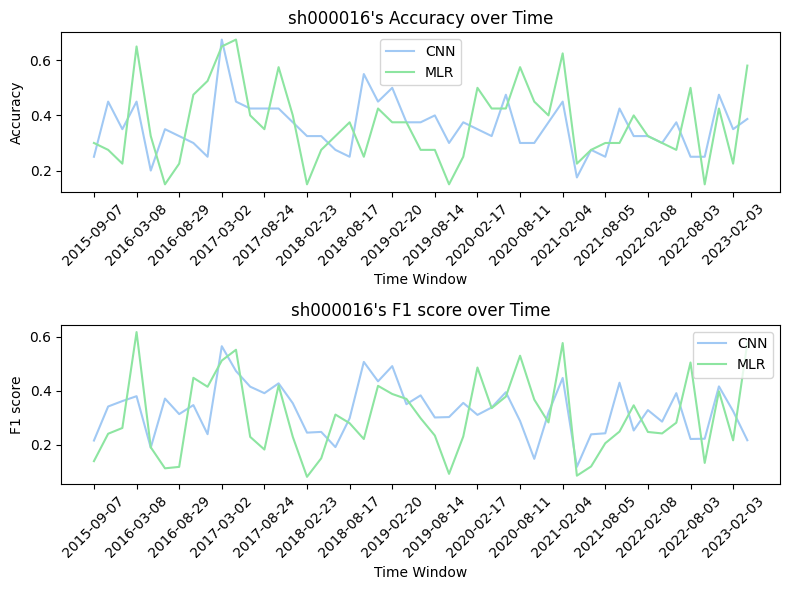

In [25]:
df016_cnn = get_master_list(index_str)[1][train_sizes.index(train_size_016)][seeds.index(seed_016)] #If need to switch between smallest variance and highest overall accuracy/f1 score, change here
df016_mlr = get_master_list(index_str)[0][train_sizes.index(train_size_016)]

x_ticks, metrics_cnn = get_metrics(df016_cnn)
_, metrics_mlr = get_metrics(df016_mlr)

# Plot the F1 score and accuracy as line graphs
fig, axs = plt.subplots(2, figsize=(8, 6))
# results.plot(y='F1 score', kind='line', ax=axs[0], xlabel='Time Window', ylabel='F1 Score', title='F1 Score over Time')
axs[0].plot(x_ticks, metrics_cnn['Accuracy'])
axs[0].plot(x_ticks, metrics_mlr['Accuracy'])
axs[0].set_xlabel("Time Window")
axs[0].set_ylabel("Accuracy")
axs[0].set_title(f"sh{index_str}'s Accuracy over Time")
axs[0].set_xticks(x_ticks[::3])
axs[0].set_xticklabels(x_ticks[::3], rotation=45)
axs[0].legend(['CNN','MLR'])

# results.plot(y='Accuracy', kind='line', ax=axs[1], xlabel='Time Window', ylabel='Accuracy', title='Accuracy over Time')
axs[1].plot(x_ticks, metrics_cnn['F1 score'])
axs[1].plot(x_ticks, metrics_mlr['F1 score'])
axs[1].set_xlabel("Time Window")
axs[1].set_ylabel("F1 score")
axs[1].set_title(f"sh{index_str}'s F1 score over Time")
axs[1].set_xticks(x_ticks[::3])
axs[1].set_xticklabels(x_ticks[::3], rotation=45)
axs[1].legend(['CNN','MLR'])
plt.tight_layout()
plt.show()

## sh000300

### MLR

In [26]:
get_scores(get_master_list('000300')[0]) 
train_size_mlr_300 = 1000

#Get MLR's accuracy and f1 score and their variances to store them in the table
df = get_master_list('000300')[0][train_sizes.index(train_size_mlr_300)]
mlr_accuracy_300 = accuracy_score(df['true'], df['prediction'])
mlr_f1_score_300 = f1_score(df['true'], df['prediction'],average = 'macro')
#np.mean(metrics_cnn['Accuracy'])

##Variance
_, metrics_mlr = get_metrics(get_master_list('000300')[0][train_sizes.index(train_size_mlr_300)])
mlr_accuracy_var_300 = np.var(metrics_mlr['Accuracy'])
mlr_f1_score_var_300 = np.var(metrics_mlr['F1 score'])

For trainng size 480:
MLR accuracy:  0.3644230769230769
MLR F1 score:  0.364964203405617
For trainng size 1000:
MLR accuracy:  0.3923076923076923
MLR F1 score:  0.3744969394143416
For trainng size 2400:
MLR accuracy:  0.28450106157112526
MLR F1 score:  0.26698177324040945


### CNN

In [27]:
get_scores(get_master_list('000300')[1])

index_str = '000300'
train_size_300 = 480

seed_300 = 403
#Get accuracy and f1 score and their variances to store them in the table
df = get_master_list(index_str)[1][train_sizes.index(train_size_300)][seeds.index(seed_300)]
avg_accuracy_300 = accuracy_score(df['true'], df['prediction'])
f1_score_300 = f1_score(df['true'], df['prediction'],average = 'macro')
#np.mean(metrics_cnn['Accuracy'])

##Variance
_, metrics_cnn = get_metrics(get_master_list(index_str)[1][train_sizes.index(train_size_300)][seeds.index(seed_300)])
accuracy_var_300 = np.var(metrics_cnn['Accuracy'])
f1_score_var_300 = np.var(metrics_cnn['F1 score'])


For trainng size 480:
Accuracy of seed 401:  0.3403846153846154
F1 score of seed 401:  0.3377057910540433
Accuracy of seed 402:  0.35
F1 score of seed 402:  0.3455440148744968
Accuracy of seed 403:  0.3644230769230769
F1 score of seed 403:  0.36312070559717197


For trainng size 1000:
Accuracy of seed 401:  0.3403846153846154
F1 score of seed 401:  0.33576994038089136
Accuracy of seed 402:  0.34423076923076923
F1 score of seed 402:  0.34568782635307294
Accuracy of seed 403:  0.3230769230769231
F1 score of seed 403:  0.31423016546067156


For trainng size 2400:
Accuracy of seed 401:  0.30148619957537154
F1 score of seed 401:  0.3016978579336077
Accuracy of seed 402:  0.35668789808917195
F1 score of seed 402:  0.3551261535293386
Accuracy of seed 403:  0.3184713375796178
F1 score of seed 403:  0.31313113136145754




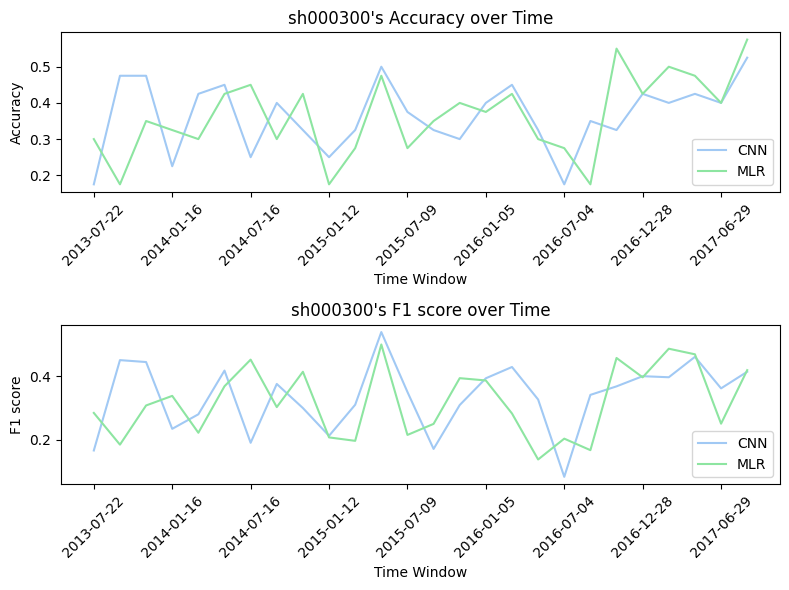

In [28]:
df300_cnn = get_master_list(index_str)[1][train_sizes.index(train_size_300)][seeds.index(seed_300)] #If need to switch between smallest variance and highest overall accuracy/f1 score, change here
df300_mlr = get_master_list(index_str)[0][train_sizes.index(train_size_300)]

x_ticks, metrics_cnn = get_metrics(df300_cnn)
_, metrics_mlr = get_metrics(df300_mlr)

# Plot the F1 score and accuracy as line graphs
fig, axs = plt.subplots(2, figsize=(8, 6))
# results.plot(y='F1 score', kind='line', ax=axs[0], xlabel='Time Window', ylabel='F1 Score', title='F1 Score over Time')
axs[0].plot(x_ticks, metrics_cnn['Accuracy'])
axs[0].plot(x_ticks, metrics_mlr['Accuracy'])
axs[0].set_xlabel("Time Window")
axs[0].set_ylabel("Accuracy")
axs[0].set_title(f"sh{index_str}'s Accuracy over Time")
axs[0].set_xticks(x_ticks[::3])
axs[0].set_xticklabels(x_ticks[::3], rotation=45)
axs[0].legend(['CNN','MLR'])

# results.plot(y='Accuracy', kind='line', ax=axs[1], xlabel='Time Window', ylabel='Accuracy', title='Accuracy over Time')
axs[1].plot(x_ticks, metrics_cnn['F1 score'])
axs[1].plot(x_ticks, metrics_mlr['F1 score'])
axs[1].set_xlabel("Time Window")
axs[1].set_ylabel("F1 score")
axs[1].set_title(f"sh{index_str}'s F1 score over Time")
axs[1].set_xticks(x_ticks[::3])
axs[1].set_xticklabels(x_ticks[::3], rotation=45)
axs[1].legend(['CNN','MLR'])
plt.tight_layout()
plt.show()

## sh000852

### MLR

In [29]:
get_scores(get_master_list('000852')[0]) 
train_size_mlr_852 = 1000

#Get MLR's accuracy and f1 score and their variances to store them in the table
df = get_master_list('000852')[0][train_sizes.index(train_size_mlr_852)]
mlr_accuracy_852 = accuracy_score(df['true'], df['prediction'])
mlr_f1_score_852 = f1_score(df['true'], df['prediction'],average = 'macro')
#np.mean(metrics_cnn['Accuracy'])

##Variance
_, metrics_mlr = get_metrics(get_master_list('000852')[0][train_sizes.index(train_size_mlr_852)])
mlr_accuracy_var_852 = np.var(metrics_mlr['Accuracy'])
mlr_f1_score_var_852 = np.var(metrics_mlr['F1 score'])


For trainng size 480:
MLR accuracy:  0.355918025930573
MLR F1 score:  0.33715216061291003
For trainng size 1000:
MLR accuracy:  0.37733832175307325
MLR F1 score:  0.3630708980255318
For trainng size 2400:
MLR accuracy:  0.3651804670912951
MLR F1 score:  0.2949028144635557


### CNN

In [30]:
get_scores(get_master_list('000852')[1])

index_str = '000852'
train_size_852 = 480

seed_852 = 401
#Get accuracy and f1 score and their variances to store them in the table
df = get_master_list(index_str)[1][train_sizes.index(train_size_852)][seeds.index(seed_852)]
avg_accuracy_852 = accuracy_score(df['true'], df['prediction'])
f1_score_852 = f1_score(df['true'], df['prediction'],average = 'macro')
#np.mean(metrics_cnn['Accuracy'])

##Variance
_, metrics_cnn = get_metrics(get_master_list(index_str)[1][train_sizes.index(train_size_852)][seeds.index(seed_852)])
accuracy_var_852 = np.var(metrics_cnn['Accuracy'])
f1_score_var_852 = np.var(metrics_cnn['F1 score'])

For trainng size 480:
Accuracy of seed 401:  0.3739021329987453
F1 score of seed 401:  0.3569720579097932
Accuracy of seed 402:  0.35549979088247596
F1 score of seed 402:  0.3458790819375428
Accuracy of seed 403:  0.36260978670012545
F1 score of seed 403:  0.352329645909024


For trainng size 1000:
Accuracy of seed 401:  0.347407803313736
F1 score of seed 401:  0.3349065720394662
Accuracy of seed 402:  0.3484767504008552
F1 score of seed 402:  0.3418784874794334
Accuracy of seed 403:  0.35168359166221275
F1 score of seed 403:  0.33272036580004616


For trainng size 2400:
Accuracy of seed 401:  0.31634819532908703
F1 score of seed 401:  0.3033716732683776
Accuracy of seed 402:  0.3036093418259023
F1 score of seed 402:  0.2996912129057944
Accuracy of seed 403:  0.3333333333333333
F1 score of seed 403:  0.3212594121401331




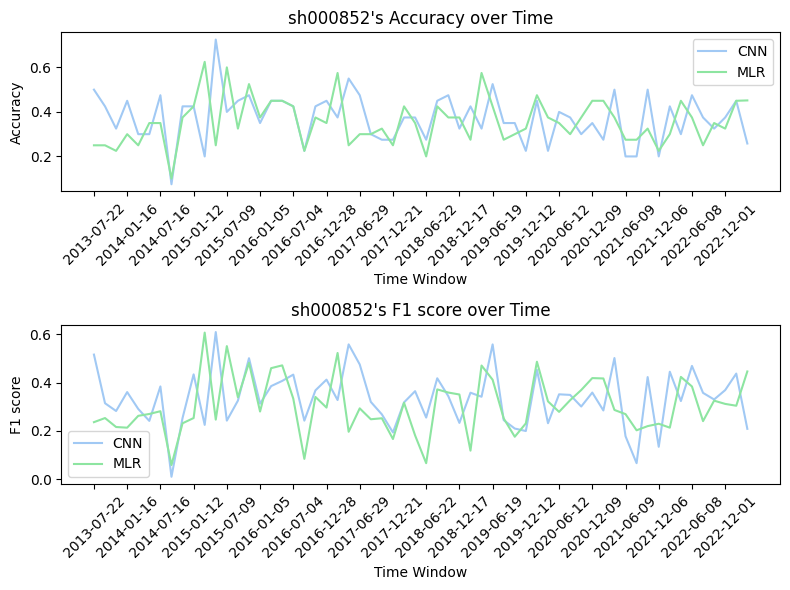

In [31]:
df852_cnn = get_master_list(index_str)[1][train_sizes.index(train_size_852)][seeds.index(seed_852)] #If need to switch between smallest variance and highest overall accuracy/f1 score, change here
df852_mlr = get_master_list(index_str)[0][train_sizes.index(train_size_852)]

x_ticks, metrics_cnn = get_metrics(df852_cnn)
_, metrics_mlr = get_metrics(df852_mlr)

# Plot the F1 score and accuracy as line graphs
fig, axs = plt.subplots(2, figsize=(8, 6))
# results.plot(y='F1 score', kind='line', ax=axs[0], xlabel='Time Window', ylabel='F1 Score', title='F1 Score over Time')
axs[0].plot(x_ticks, metrics_cnn['Accuracy'])
axs[0].plot(x_ticks, metrics_mlr['Accuracy'])
axs[0].set_xlabel("Time Window")
axs[0].set_ylabel("Accuracy")
axs[0].set_title(f"sh{index_str}'s Accuracy over Time")
axs[0].set_xticks(x_ticks[::3])
axs[0].set_xticklabels(x_ticks[::3], rotation=45)
axs[0].legend(['CNN','MLR'])

# results.plot(y='Accuracy', kind='line', ax=axs[1], xlabel='Time Window', ylabel='Accuracy', title='Accuracy over Time')
axs[1].plot(x_ticks, metrics_cnn['F1 score'])
axs[1].plot(x_ticks, metrics_mlr['F1 score'])
axs[1].set_xlabel("Time Window")
axs[1].set_ylabel("F1 score")
axs[1].set_title(f"sh{index_str}'s F1 score over Time")
axs[1].set_xticks(x_ticks[::3])
axs[1].set_xticklabels(x_ticks[::3], rotation=45)
axs[1].legend(['CNN','MLR'])
plt.tight_layout()
plt.show()

## sh000903

### MLR

In [32]:
get_scores(get_master_list('000903')[0]) 
train_size_mlr_903 = 1000

#Get MLR's accuracy and f1 score and their variances to store them in the table
df = get_master_list('000903')[0][train_sizes.index(train_size_mlr_903)]
mlr_accuracy_903 = accuracy_score(df['true'], df['prediction'])
mlr_f1_score_903 = f1_score(df['true'], df['prediction'],average = 'macro')
#np.mean(metrics_cnn['Accuracy'])

##Variance
_, metrics_mlr = get_metrics(get_master_list('000903')[0][train_sizes.index(train_size_mlr_903)])
mlr_accuracy_var_903 = np.var(metrics_mlr['Accuracy'])
mlr_f1_score_var_903 = np.var(metrics_mlr['F1 score'])


For trainng size 480:
MLR accuracy:  0.3458803847762443
MLR F1 score:  0.34600718323132695
For trainng size 1000:
MLR accuracy:  0.3607696419027258
MLR F1 score:  0.36107090702119143
For trainng size 2400:
MLR accuracy:  0.34394904458598724
MLR F1 score:  0.31023255208672224


### CNN

In [33]:
get_scores(get_master_list('000903')[1])

index_str = '000903'
train_size_903 = 2400

seed_903 = 401
#Get accuracy and f1 score and their variances to store them in the table
df = get_master_list(index_str)[1][train_sizes.index(train_size_903)][seeds.index(seed_903)]
avg_accuracy_903 = accuracy_score(df['true'], df['prediction'])
f1_score_903 = f1_score(df['true'], df['prediction'],average = 'macro')
#np.mean(metrics_cnn['Accuracy'])

##Variance
_, metrics_cnn = get_metrics(get_master_list(index_str)[1][train_sizes.index(train_size_903)][seeds.index(seed_903)])
accuracy_var_903 = np.var(metrics_cnn['Accuracy'])
f1_score_var_903 = np.var(metrics_cnn['F1 score'])

For trainng size 480:
Accuracy of seed 401:  0.34044332915098285
F1 score of seed 401:  0.3382367196756812
Accuracy of seed 402:  0.3437892095357591
F1 score of seed 402:  0.3407545937190206
Accuracy of seed 403:  0.33500627352572143
F1 score of seed 403:  0.3345814498244197


For trainng size 1000:
Accuracy of seed 401:  0.344735435595938
F1 score of seed 401:  0.342298056904659
Accuracy of seed 402:  0.34206306787814006
F1 score of seed 402:  0.3404825318517189
Accuracy of seed 403:  0.3324425440940673
F1 score of seed 403:  0.33195303128716563


For trainng size 2400:
Accuracy of seed 401:  0.3630573248407643
F1 score of seed 401:  0.3575410841460138
Accuracy of seed 402:  0.2951167728237792
F1 score of seed 402:  0.2950492345585976
Accuracy of seed 403:  0.32696390658174096
F1 score of seed 403:  0.3195389452501131




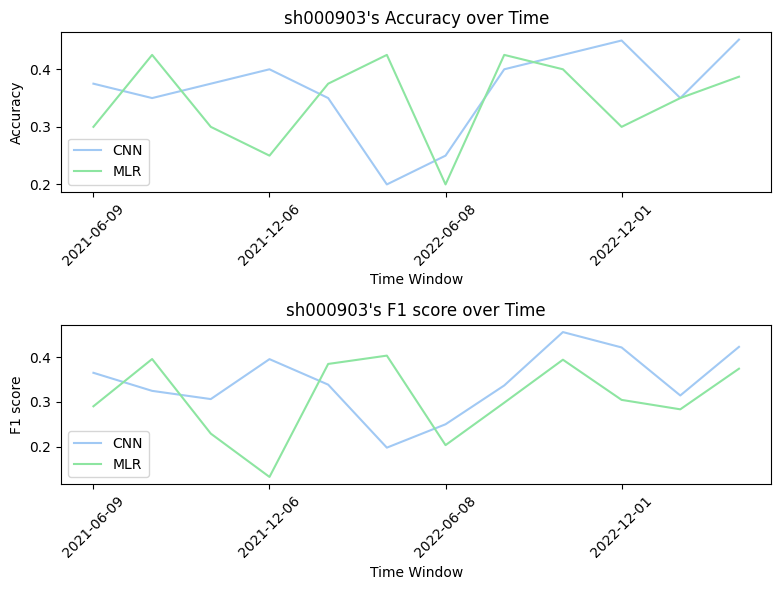

In [34]:
df903_cnn = get_master_list(index_str)[1][train_sizes.index(train_size_903)][seeds.index(seed_903)] #If need to switch between smallest variance and highest overall accuracy/f1 score, change here
df903_mlr = get_master_list(index_str)[0][train_sizes.index(train_size_903)]

x_ticks, metrics_cnn = get_metrics(df903_cnn)
_, metrics_mlr = get_metrics(df903_mlr)

# Plot the F1 score and accuracy as line graphs
fig, axs = plt.subplots(2, figsize=(8, 6))
# results.plot(y='F1 score', kind='line', ax=axs[0], xlabel='Time Window', ylabel='F1 Score', title='F1 Score over Time')
axs[0].plot(x_ticks, metrics_cnn['Accuracy'])
axs[0].plot(x_ticks, metrics_mlr['Accuracy'])
axs[0].set_xlabel("Time Window")
axs[0].set_ylabel("Accuracy")
axs[0].set_title(f"sh{index_str}'s Accuracy over Time")
axs[0].set_xticks(x_ticks[::3])
axs[0].set_xticklabels(x_ticks[::3], rotation=45)
axs[0].legend(['CNN','MLR'])

# results.plot(y='Accuracy', kind='line', ax=axs[1], xlabel='Time Window', ylabel='Accuracy', title='Accuracy over Time')
axs[1].plot(x_ticks, metrics_cnn['F1 score'])
axs[1].plot(x_ticks, metrics_mlr['F1 score'])
axs[1].set_xlabel("Time Window")
axs[1].set_ylabel("F1 score")
axs[1].set_title(f"sh{index_str}'s F1 score over Time")
axs[1].set_xticks(x_ticks[::3])
axs[1].set_xticklabels(x_ticks[::3], rotation=45)
axs[1].legend(['CNN','MLR'])
plt.tight_layout()
plt.show()


## sh000905

### MLR

In [35]:
get_scores(get_master_list('000905')[0]) 
train_size_mlr_905 = 1000

#Get MLR's accuracy and f1 score and their variances to store them in the table
df = get_master_list('000905')[0][train_sizes.index(train_size_mlr_905)]
mlr_accuracy_905 = accuracy_score(df['true'], df['prediction'])
mlr_f1_score_905 = f1_score(df['true'], df['prediction'],average = 'macro')
#np.mean(metrics_cnn['Accuracy'])

##Variance
_, metrics_mlr = get_metrics(get_master_list('000905')[0][train_sizes.index(train_size_mlr_905)])
mlr_accuracy_var_905 = np.var(metrics_mlr['Accuracy'])
mlr_f1_score_var_905 = np.var(metrics_mlr['F1 score'])

For trainng size 480:
MLR accuracy:  0.34880803011292344
MLR F1 score:  0.3370652187302636
For trainng size 1000:
MLR accuracy:  0.3607696419027258
MLR F1 score:  0.3527227802753539
For trainng size 2400:
MLR accuracy:  0.30148619957537154
MLR F1 score:  0.29111626329105267


### CNN

In [36]:
get_scores(get_master_list('000905')[1])

index_str = '000905'
train_size_905 = 480

seed_905 = 401
#Get accuracy and f1 score and their variances to store them in the table
df = get_master_list(index_str)[1][train_sizes.index(train_size_905)][seeds.index(seed_905)]
avg_accuracy_905 = accuracy_score(df['true'], df['prediction'])
f1_score_905 = f1_score(df['true'], df['prediction'],average = 'macro')
#np.mean(metrics_cnn['Accuracy'])

##Variance
_, metrics_cnn = get_metrics(get_master_list(index_str)[1][train_sizes.index(train_size_905)][seeds.index(seed_905)])
accuracy_var_905 = np.var(metrics_cnn['Accuracy'])
f1_score_var_905 = np.var(metrics_cnn['F1 score'])

For trainng size 480:
Accuracy of seed 401:  0.383521539104977
F1 score of seed 401:  0.3748803536481711
Accuracy of seed 402:  0.3743203680468423
F1 score of seed 402:  0.3675877652953756
Accuracy of seed 403:  0.3718109577582601
F1 score of seed 403:  0.361681370690117


For trainng size 1000:
Accuracy of seed 401:  0.3607696419027258
F1 score of seed 401:  0.355098762304826
Accuracy of seed 402:  0.35916622127204706
F1 score of seed 402:  0.35295287003713915
Accuracy of seed 403:  0.36130411544628543
F1 score of seed 403:  0.35575869129605353


For trainng size 2400:
Accuracy of seed 401:  0.2908704883227176
F1 score of seed 401:  0.2913007877816276
Accuracy of seed 402:  0.3333333333333333
F1 score of seed 402:  0.3288210740504587
Accuracy of seed 403:  0.34394904458598724
F1 score of seed 403:  0.3424744916344682




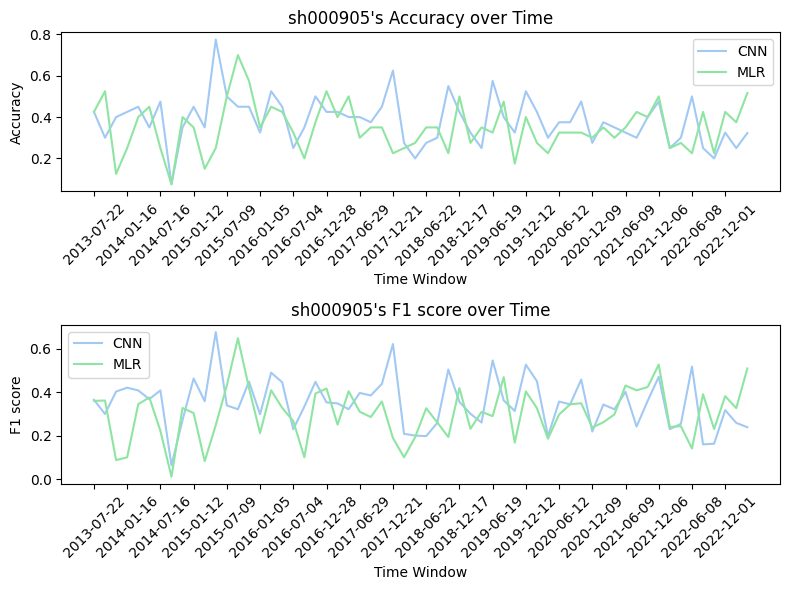

In [37]:
df905_cnn = get_master_list(index_str)[1][train_sizes.index(train_size_905)][seeds.index(seed_905)] #If need to switch between smallest variance and highest overall accuracy/f1 score, change here
df905_mlr = get_master_list(index_str)[0][train_sizes.index(train_size_905)]

x_ticks, metrics_cnn = get_metrics(df905_cnn)
_, metrics_mlr = get_metrics(df905_mlr)

# Plot the F1 score and accuracy as line graphs
fig, axs = plt.subplots(2, figsize=(8, 6))
# results.plot(y='F1 score', kind='line', ax=axs[0], xlabel='Time Window', ylabel='F1 Score', title='F1 Score over Time')
axs[0].plot(x_ticks, metrics_cnn['Accuracy'])
axs[0].plot(x_ticks, metrics_mlr['Accuracy'])
axs[0].set_xlabel("Time Window")
axs[0].set_ylabel("Accuracy")
axs[0].set_title(f"sh{index_str}'s Accuracy over Time")
axs[0].set_xticks(x_ticks[::3])
axs[0].set_xticklabels(x_ticks[::3], rotation=45)
axs[0].legend(['CNN','MLR'])

# results.plot(y='Accuracy', kind='line', ax=axs[1], xlabel='Time Window', ylabel='Accuracy', title='Accuracy over Time')
axs[1].plot(x_ticks, metrics_cnn['F1 score'])
axs[1].plot(x_ticks, metrics_mlr['F1 score'])
axs[1].set_xlabel("Time Window")
axs[1].set_ylabel("F1 score")
axs[1].set_title(f"sh{index_str}'s F1 score over Time")
axs[1].set_xticks(x_ticks[::3])
axs[1].set_xticklabels(x_ticks[::3], rotation=45)
axs[1].legend(['CNN','MLR'])
plt.tight_layout()
plt.show()

In [38]:
# choices for MLR
data = {'index': ['sh000016', 'sh000300', 'sh000852','sh000903','sh000905'],
        'best train size': [train_size_mlr_016,train_size_mlr_300 , train_size_mlr_852,
                            train_size_mlr_903,train_size_mlr_905],
       }

# create a dataframe from the dictionary
df_mlr = pd.DataFrame(data)

# print the dataframe
print(df_mlr)

      index  best train size
0  sh000016             1000
1  sh000300             1000
2  sh000852             1000
3  sh000903             1000
4  sh000905             1000


In [39]:
# choices for CNN
data = {'index': ['sh000016', 'sh000300', 'sh000852','sh000903','sh000905'],
        'best train size': [train_size_016,train_size_300 , train_size_852,train_size_903,train_size_905],
        'best seed': [seed_016, seed_300, seed_852,seed_903,seed_905],
#         'accuracy':[avg_accuracy_016,avg_accuracy_300,avg_accuracy_852,avg_accuracy_903,avg_accuracy_905],
#         'accuracy variance': [accuracy_var_016,accuracy_var_300,accuracy_var_852,accuracy_var_903,accuracy_var_905],
#         'f1 score': [f1_score_016,f1_score_300,f1_score_852,f1_score_903,f1_score_905], 
#         'f1 score variance': [f1_score_var_016,f1_score_var_300,f1_score_var_852,f1_score_var_903,f1_score_var_905]
       }
        

# create a dataframe from the dictionary
df_cnn = pd.DataFrame(data)

# print the dataframe
print(df_cnn)

      index  best train size  best seed
0  sh000016             1000        402
1  sh000300              480        403
2  sh000852              480        401
3  sh000903             2400        401
4  sh000905              480        401


In [40]:
# create the accuracy table
data = {'index': ['sh000016', 'sh000300', 'sh000852','sh000903','sh000905'],
        'MLR':[f'{mlr_accuracy_016:.3f}+/-{mlr_accuracy_var_016**(1/2):.3f}',
              f'{mlr_accuracy_300:.3f}+/-{mlr_accuracy_var_300**(1/2):.3f}',
              f'{mlr_accuracy_852:.3f}+/-{mlr_accuracy_var_852**(1/2):.3f}',
              f'{mlr_accuracy_903:.3f}+/-{mlr_accuracy_var_903**(1/2):.3f}',
              f'{mlr_accuracy_905:.3f}+/-{mlr_accuracy_var_905**(1/2):.3f}'],
        'CNN':[f'{avg_accuracy_016:.3f}+/-{accuracy_var_016**(1/2):.3f}',
               f'{avg_accuracy_300:.3f}+/-{accuracy_var_300**(1/2):.3f}',
               f'{avg_accuracy_852:.3f}+/-{accuracy_var_852**(1/2):.3f}',
               f'{avg_accuracy_903:.3f}+/-{accuracy_var_903**(1/2):.3f}',
               f'{avg_accuracy_905:.3f}+/-{accuracy_var_905**(1/2):.3f}']}

# create a dataframe from the dictionary
df_accuracy = pd.DataFrame(data)

# print the dataframe
print("Accuracy Result Table: \n")
print(df_accuracy)

Accuracy Result Table: 

      index            MLR            CNN
0  sh000016  0.369+/-0.140  0.360+/-0.094
1  sh000300  0.392+/-0.127  0.364+/-0.094
2  sh000852  0.377+/-0.103  0.374+/-0.109
3  sh000903  0.361+/-0.111  0.363+/-0.072
4  sh000905  0.361+/-0.118  0.384+/-0.113


In [41]:
# create the f1 score table
data = {'index': ['sh000016', 'sh000300', 'sh000852','sh000903','sh000905'],
        'MLR':[f'{mlr_f1_score_016:.3f}+/-{mlr_f1_score_var_016**(1/2):.3f}',
              f'{mlr_f1_score_300:.3f}+/-{mlr_f1_score_var_300**(1/2):.3f}',
              f'{mlr_f1_score_852:.3f}+/-{mlr_f1_score_var_852**(1/2):.3f}',
              f'{mlr_f1_score_903:.3f}+/-{mlr_f1_score_var_903**(1/2):.3f}',
              f'{mlr_f1_score_905:.3f}+/-{mlr_f1_score_var_905**(1/2):.3f}'],
        'CNN':[f'{f1_score_016:.3f}+/-{f1_score_var_016**(1/2):.3f}',
               f'{f1_score_300:.3f}+/-{f1_score_var_300**(1/2):.3f}',
               f'{f1_score_852:.3f}+/-{f1_score_var_852**(1/2):.3f}',
               f'{f1_score_903:.3f}+/-{f1_score_var_903**(1/2):.3f}',
               f'{f1_score_905:.3f}+/-{f1_score_var_905**(1/2):.3f}']}

# create a dataframe from the dictionary
df_f1_score = pd.DataFrame(data)

# print the dataframe
print("F1 Score Result Table: \n")
print(df_f1_score)

F1 Score Result Table: 

      index            MLR            CNN
0  sh000016  0.368+/-0.145  0.360+/-0.096
1  sh000300  0.374+/-0.130  0.363+/-0.106
2  sh000852  0.363+/-0.110  0.357+/-0.115
3  sh000903  0.361+/-0.123  0.358+/-0.071
4  sh000905  0.353+/-0.122  0.375+/-0.115


### Best Hyperparameters Over Time

In [42]:
def get_para_list(index_str):
    # Construct file paths using index_str
    mlr_para_480_path = f"../model/mlr_{index_str}_tr480_va40_te40/hyperparam.csv"
    mlr_para_1000_path = f"../model/mlr_{index_str}_tr1000_va40_te40/hyperparam.csv"
    mlr_para_2400_path = f"../model/mlr_{index_str}_tr2400_va40_te40/hyperparam.csv"
    cnn_para_480_path_template = f"../model/CNN_{index_str}_tr480_va40_te40_lr0.005_e200_seed{{}}/hyperparam.csv"
    cnn_para_1000_path_template = f"../model/CNN_{index_str}_tr1000_va40_te40_lr0.005_e200_seed{{}}/hyperparam.csv"
    cnn_para_2400_path_template = f"../model/CNN_{index_str}_tr2400_va40_te40_lr0.005_e200_seed{{}}/hyperparam.csv"
    
    # Read the data files
    mlr_para_480 = pd.read_csv(mlr_para_480_path)
    mlr_para_1000 = pd.read_csv(mlr_para_1000_path)
    mlr_para_2400 = pd.read_csv(mlr_para_2400_path)
    cnn_para_480 = [pd.read_csv(cnn_para_480_path_template.format(seed)) for seed in [401, 402, 403]]
    cnn_para_1000 = [pd.read_csv(cnn_para_1000_path_template.format(seed)) for seed in [401, 402, 403]]
    cnn_para_2400 = [pd.read_csv(cnn_para_2400_path_template.format(seed)) for seed in [401, 402, 403]]
    
    # Create master data list
    para_list = [[mlr_para_480, mlr_para_1000, mlr_para_2400], [cnn_para_480, cnn_para_1000, cnn_para_2400]]
    
    return para_list


In [43]:
def plot_index_best_para(index_str, train_size):
    """Time series plots of the index stock for all 3 best hyperparameters."""

    fig, axes = plt.subplots(3, 1, figsize=(8, 6))

    if train_size == 480:
        idx = 0
    elif train_size == 1000:
        idx = 1
    else:
        idx = 2

    mlr_para = get_para_list(index_str)[0][idx]
    cnn_para = get_para_list(index_str)[1][idx][0]

    # best C for mlr
    axes[0].plot(mlr_para["end_date"], mlr_para["best_c"], label="Best C")
    axes[0].set_xlabel("Time Window")
    axes[0].set_ylabel("Best C for MLR")
    axes[0].set_title("Best C - MLR")
    axes[0].set_xticks(mlr_para["end_date"][::3])
    axes[0].set_xticklabels(mlr_para["end_date"][::3], rotation=45)

    # best scale for cnn
    axes[1].plot(cnn_para["end_date"], cnn_para["scale"], color="red")
    axes[1].set_xlabel("Time Window")
    axes[1].set_ylabel("Best Scale for CNN")
    axes[1].set_title("Best Scale - CNN")
    axes[1].set_xticks(cnn_para["end_date"][::3])
    axes[1].set_xticklabels(cnn_para["end_date"][::3], rotation=45)

    # best hidden state for cnn
    axes[2].plot(cnn_para["end_date"], cnn_para["gru_hidden"], color="orange")
    axes[2].set_xlabel("Time Window")
    axes[2].set_ylabel("Best GRU Hidden for CNN")
    axes[2].set_title("Best GRU Hidden - CNN")
    axes[2].set_xticks(cnn_para["end_date"][::3])
    axes[2].set_xticklabels(cnn_para["end_date"][::3], rotation=45)

    plt.suptitle(f"Best Hyperparamters of MLR and CNN Over Time for sh{index_str}")
    plt.tight_layout()
    plt.show()
    

### sh000016

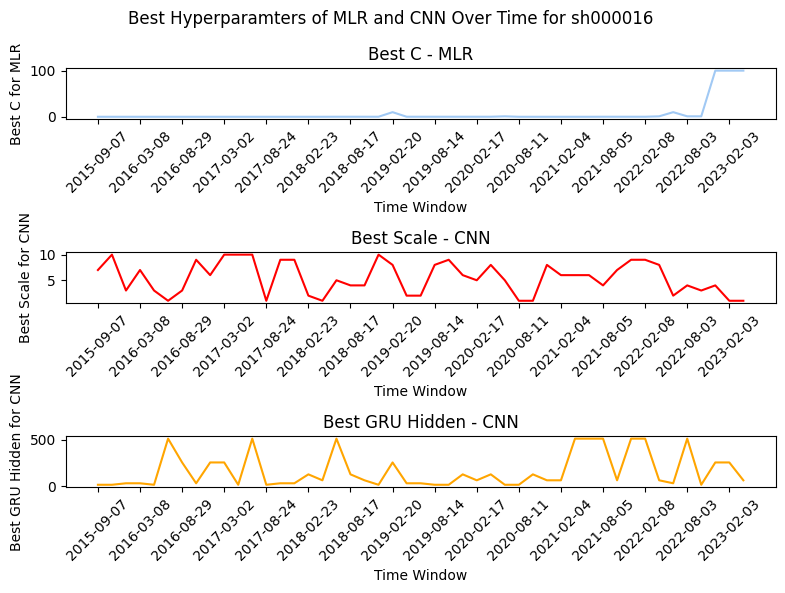

In [44]:
# train_size is selected above
plot_index_best_para("000016", train_size_016)

### sh000300

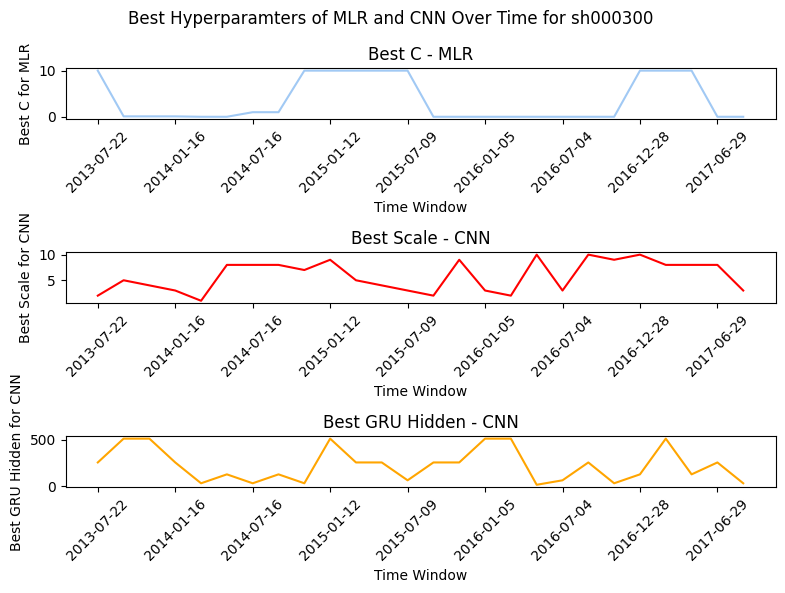

In [45]:
plot_index_best_para("000300", train_size_300)

### sh000852

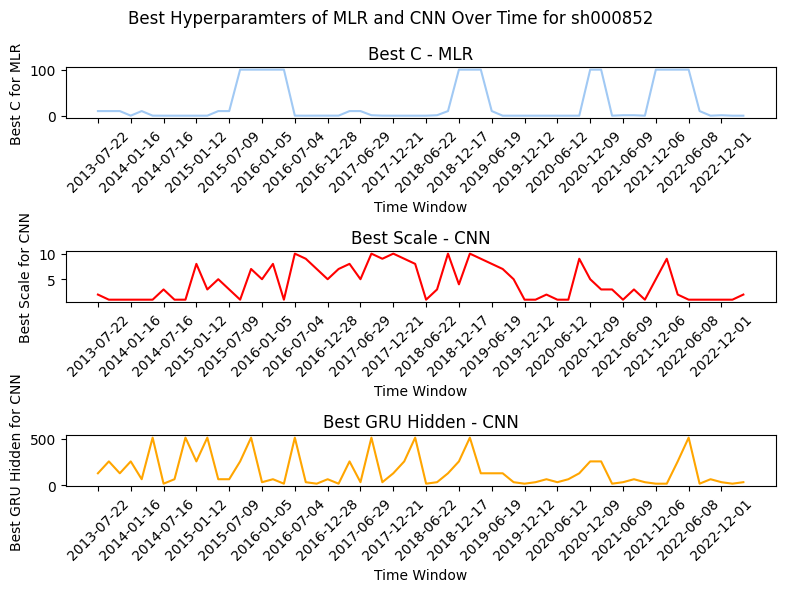

In [46]:
plot_index_best_para("000852", train_size_852)

### sh000903

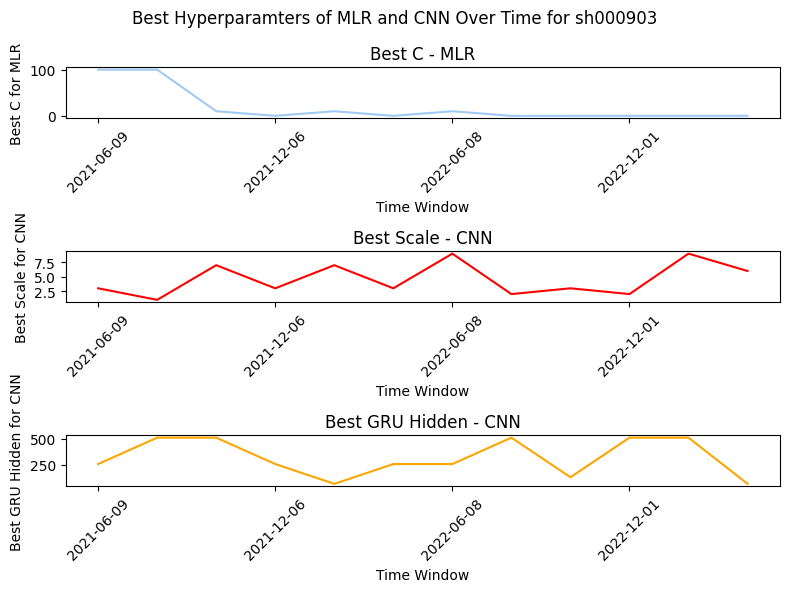

In [47]:
plot_index_best_para("000903", train_size_903)

### sh000905

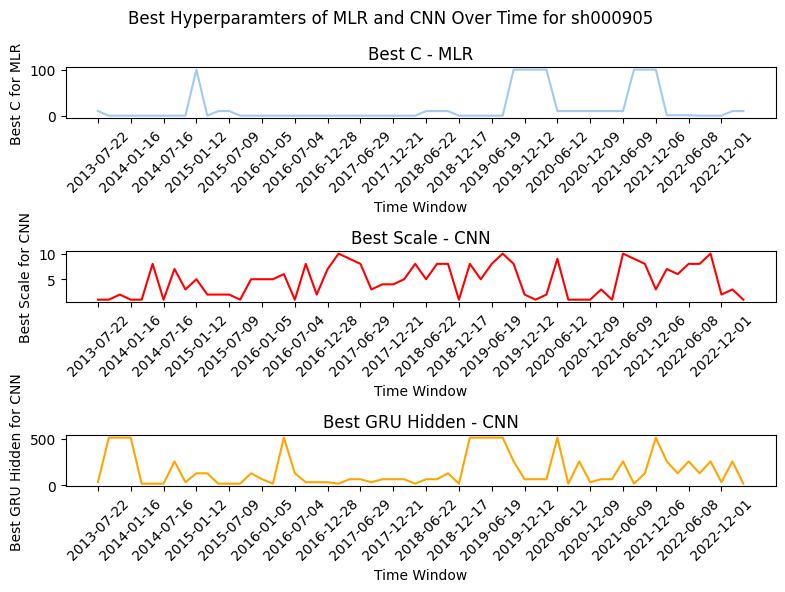

In [48]:
plot_index_best_para("000905", train_size_905)

Summary of Analysis:

- As for the results, we look at both the performance metrics and the best hyperparameters over time. For the performance metrics, we computed accuracy and F1 score plus or minus 1 standard deviation that is computed across different test sets. We can generally observe that CNN performs slightly better for sh000903 and sh000905 which both have mid-market caps. In addition, CNN yields lower variance in general. 

- For the best hyperparameters over time, we can see that the best regularization coefficient of MLR fluctuates less than the best scale and number of GRU hidden states of CNN for all 5 indices.

- The results above can help us conclude that firstly, CNN is more flexible to uncover patterns and give consistent predictions in terms of lower variance. Secondly, CNN is more sensitive to market cap. Thirdly, CNN is in general not robust to different times in terms of accuracy and macro F1 score.

## Conclusion <a class="anchor" id="conclusion"></a>

In this project, we proposed a multiscale CNN model for stock trend prediction and applied the model on five major Chinese indices. We use a specific time series train test split to select hyperparameters and evaluate our method against the multilogistic regression baseline. CNN outperforms MLR in only a limited number of regimes, which indicates CNN's sensitivity to market capitalization and different time domains. This suggests a great room for improvement and future works.

## Future Works <a class="anchor" id="future"></a>

- Use richer dataset: we may apply our architecture on individual stock predictions. Stock features are richer than indices and are of higher temporal resolutions;
- Ensemble it: we may stack our model with interpretable baselines to boost performance. In this case it worths trying to stack MLR with CNN to see if there is any performance gain.

## Thank all AC 209B Staffs!